# Modeling & Customer Segmentation

In the previous [notebook](https://github.com/NickD-Dean/Springboard/blob/bc9d26edbccb4a4fafafee14738975234cbb2b7e/Capstone%20Project%203/Code/05%20-%20Customer%20Segmentation%20Pre-processing%20and%20Training.ipynb) I prepared the customer segmentation data set for clustering and developed an initial model.  

That model produced a silhouette score of 0.07, far below that which would find any structures of note in the data for clustering purposes.  As a result I identified these steps to take to further work with the data and product better results with the clustering model.


1. Apply an agglomerative clustering model to the data and get a baseline score for that model as well. 


2. Examine clusters from both the Agglomerative and KMeans models to see if the clusters provide clear personas.


**If needed**

3. Apply PCA (MCA) to categorical data and try clustering with that transformed data


4. Remove households which are ONLY outliers in more than one feature if there seems to be no pattern with the way outliers are clustered.


5. Remove one pair of all 'high' correlated features for clustering


6. Provide customer segments via RFM analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from scipy import stats
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.cm as cm
%matplotlib inline
# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")
#setup Pandas
pd.set_option('display.max_columns', None)

In [2]:
# Reading in Data
cat = pd.read_parquet('../Data/Cust_seg_categorical')
num = pd.read_parquet('../Data/Cust_seg_numerical')
data = pd.read_parquet('../Data/Cust_seg')

#### Evaluation of clusters

While the elbow method and silhouette scores are helpful for identifying the optimal number of clusters, what I'll use to evaluate the resulting clusters is analysis of the clusters each algorithm produces to see if they provide relevant customer segments and/or insights. 

First I'm going to identify the ideal number of K using the above methods, then examine the resulting clusters for useful insights.

While I have dozens of features I can examine in order to identify clusters, I'm going to examine specific features that are useful for customer segmentation and business health:

- Average sales value

- Monetary value (Lifetime Value)

- Recency

- Frequency

- Percentage of products purchased which were displayed in store or in a mailer

- Percentage of purchased from Private brands vs National

- Age

- Income 

- Child status

### Baseline model using an agglomerative clustering algorithm

Before I begin to iterate using KMeans, I want to get an understanding of whether or note an agglomarative model will perform better than KMeans. 

I should note that using the default for Agglomerative Clustering is to converge on two clusters, and to use 'ward' linkage to reducethe variance in the clusters uncovered. 

In [3]:
model = AgglomerativeClustering()
labels = model.fit_predict(data)

In [4]:
score = silhouette_score(data, labels)
print('A baseline agglomerative model provides a mean silhouette score of: ', score)

A baseline agglomerative model provides a mean silhouette score of:  0.158907229093746


While an agglomerative model does provide a marginally better structure to the data over the baseline score from a KMeans algorithm, I'll need to examine these clusters in more detail before I'm able to draw conclusions. 

###  Finding the ideal 'k' for K-Means algorithm. 

The next step is to apply the elbow method in order to identify the ideal value for K with the KMeans algorithm. In order to do this I'll use the model demonstrated in a previous customer segmentation excercise from the Springboard course which can be found [here](https://github.com/NickD-Dean/Springboard/blob/bc9d26edbccb4a4fafafee14738975234cbb2b7e/Case%20Studies/Customer%20Segmentation%20&%20Clustering/Clustering%20Case%20Study%20-%20Customer%20Segmentation%20with%20K-Means%20-%20Tier%203.ipynb)

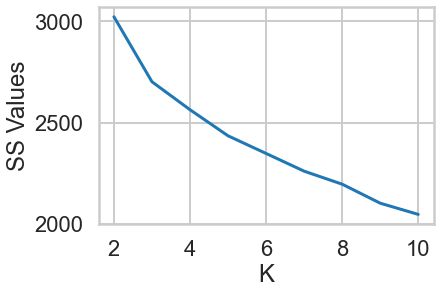

In [5]:
# Finding the sum of squares for each value of K from 2 to 11
SS=[]
Range = list(range(2,11))
X_cols = data.to_numpy()
K_models ={}

for k in Range:
    model = KMeans(n_clusters=k)
    fit_model = model.fit_predict(X_cols)
    centroids = model.cluster_centers_
    SS.append(np.sum((X_cols - centroids[fit_model])**2))
    K_models[str(k)] = fit_model

plt.plot(Range, SS)
plt.xlabel('K')
plt.ylabel('SS Values');

Okay, here we can see that while there is somewhat of an elbow around k = 5, the average sum of squares is huge.  This indicates that there are clearly some other issues going on with the data set.  

I'm going to apply a similar iterative approach using the silhouette scores to attempt to visualize the best silhouette score. 

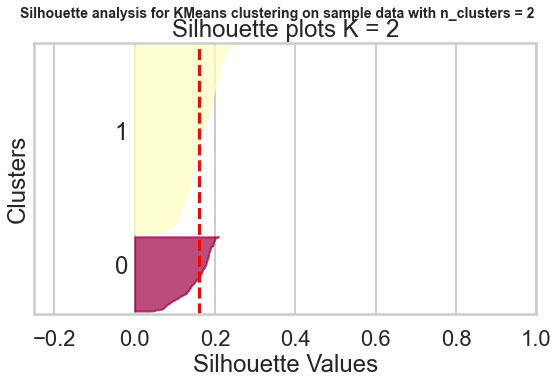

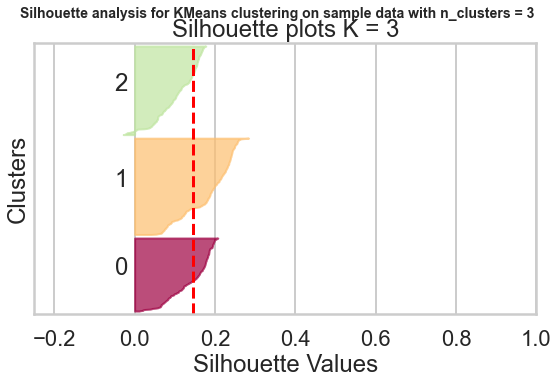

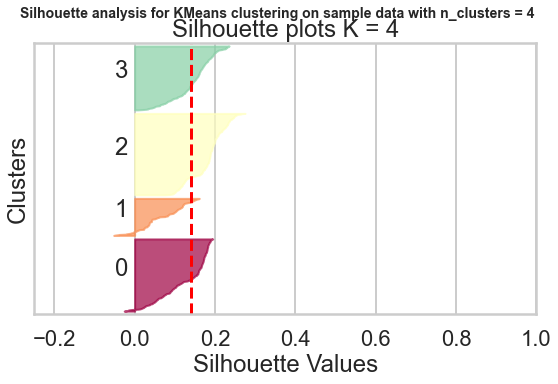

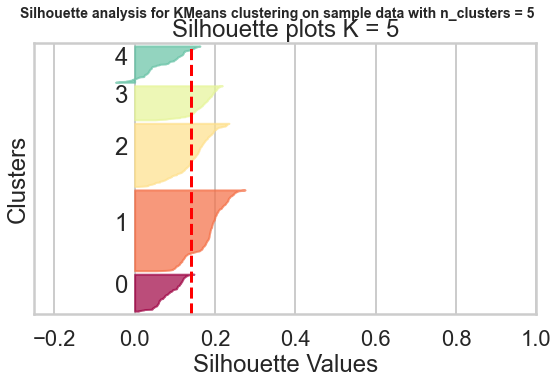

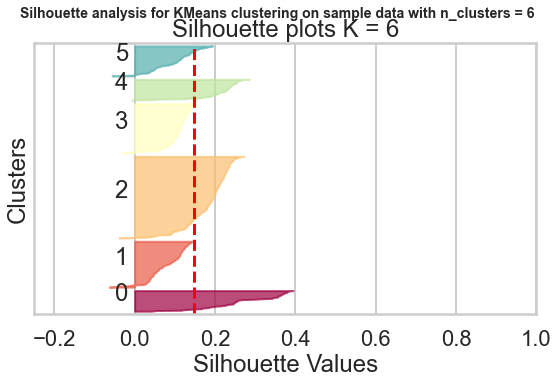

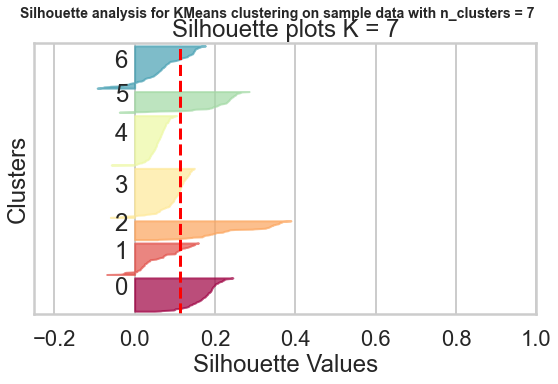

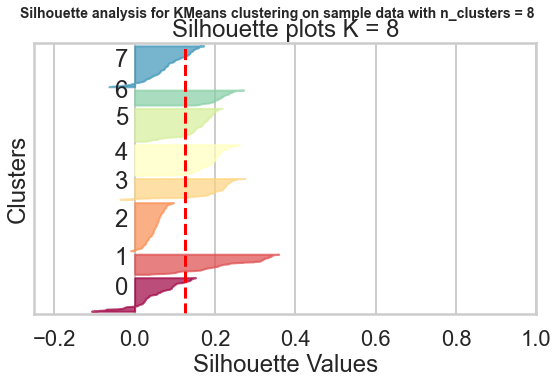

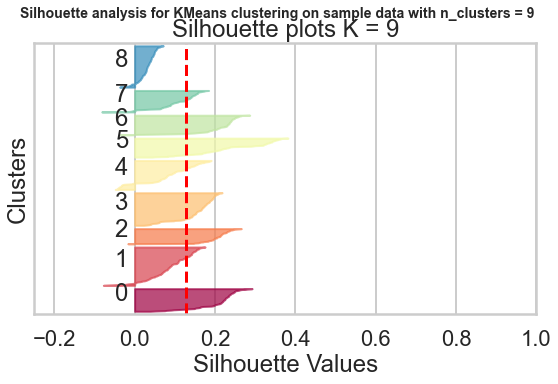

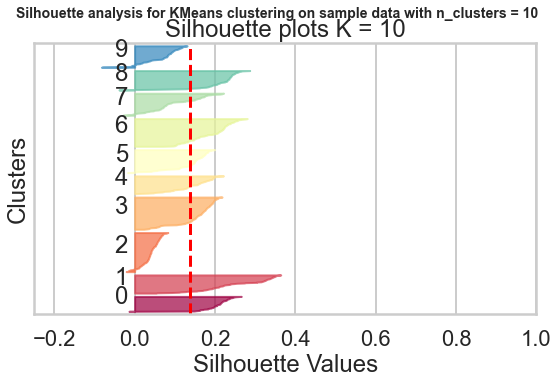

In [6]:
Range = list(range(2,11))
avg_ss =[]
for k in Range:
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(9,5)
    # instatiate the model for 'k' and find labels
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_cols)
    # Calculate & append avg score to list
    s_avg = silhouette_score(X_cols, labels)
    avg_ss.append(s_avg)
    # Calculate individual S-scores to plot
    sample_scores = silhouette_samples(X_cols, labels)
    # Setting axis limits for each plot
    ax1.set_xlim([-0.25, 1])
    ax1.set_ylim([0, len(X_cols) + (k + 1) * 10])
    # declare value of y for use in for loop
    y_lower=10
    for i in range(k):
        # aggregate S-scores for each cluster
        ith_cluster_vals = sample_scores[labels == i]  
        ith_cluster_vals.sort()
        size_cluster_i = ith_cluster_vals.shape[0]
        y_upper = size_cluster_i + y_lower
        # Set up color map for each plot
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i)/k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_vals, facecolor=color, 
                          edgecolor=color, alpha=0.7)
        # Labelling each individual cluster plot
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    # Labelling each plot for each value of k
    ax1.set_title('Silhouette plots K = %d' % k)
    ax1.set_ylabel('Clusters')
    ax1.set_xlabel('Silhouette Values')
    
    ax1.axvline(x=s_avg, color='red', linestyle='--')
    ax1.set_yticks([])
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % k), 
                 fontsize=14, fontweight='bold')

Based on the plot of the sum of squares and silhouette scores the strongest structure seems to be found at K=8 and K=10, I'll initially use the labels found at K=8, then if needed analyze the clusters for K=10.  

### Finding the ideal # of clusters for Agglomerative Clustering

Plotting a denrogram to visualize the relationships.  The function defined below is pulled from sklearn's [examples](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html) section.

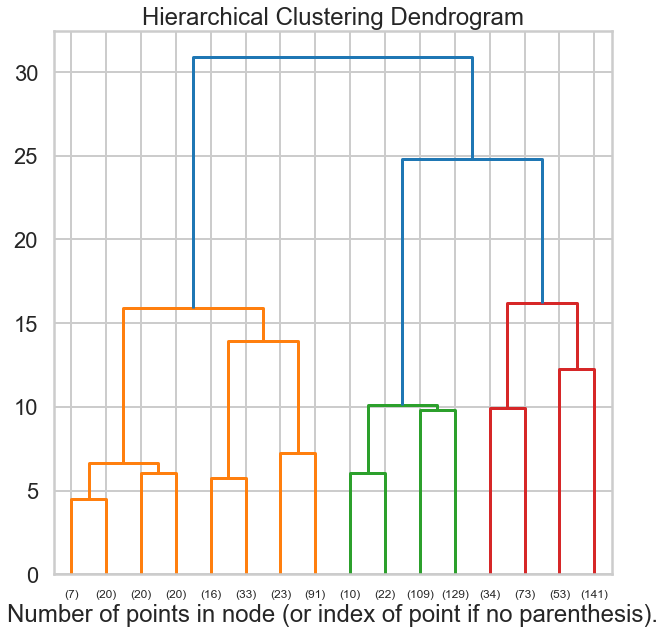

In [7]:
# Below code is from Scikit-learn

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


X = data

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.figure(figsize=(10,10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show();

It seems that there's an idean number of clusters for the agglomerative clusters at n_clusters=3, however I'm going to start with the default 2 clusters and iterate from there.

### Creating the labels for both KMeans and Agglomerative clusters for analysis. 

In [8]:
# Generating clusters from KMeans algorithm
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit_predict(data)
k_labels = kmeans.labels_

In [9]:
# Generating clusters from Agglomerative algorithm
model = AgglomerativeClustering(n_clusters=3)
a_labels = model.fit_predict(data)

In [10]:
# Loading in datat that has not been one-hot encoded or had values scaled for clustering analysis
results = pd.read_parquet('../Data/Trimmed_Data')
# Dropping columns which were dropped in preprocessing
results = results.drop(['CampaignsRedeemed', 'CouponRedeemed_Count', 'TypeA', 'TypeB', 'TypeC', 'Min_loyal_disc', 
                        'Avg_trips_week', 'Most_freq_product', 'Least_freq_product', 'High_volume_product', 
                        'Most_freq_store'], axis=1)
results['Marital_status'].replace({'A':'Married', 'B':'Single', 'U':'Unknown'})

1       Married
7       Married
8       Unknown
13      Unknown
16       Single
         ...   
2494    Unknown
2496    Married
2497    Unknown
2498    Unknown
2499    Unknown
Name: Marital_status, Length: 801, dtype: object

In [11]:
results['K_labels'] = k_labels
results['A_labels'] = a_labels

In [12]:
# I'm going to break down most_freqeunt_time from actual timestamps to either morning, afternoon, evening shoppers

Time = results.Most_freq_time

Time = Time.astype('float')
Time = Time.astype('int')
results['Most_freq_time'] = Time
# Define function to map to the Time series

def himidlow(x):
    if x < 1200: return 'Morning'
    elif x >= 1200 and x < 1700: return 'Afternoon'
    elif x >= 1700: return 'Evening'

results['Time'] = results['Most_freq_time'].map(himidlow)
results.drop('Most_freq_time', axis=1, inplace=True)

In [13]:
results.head()

Age Marital_status  Income Homeowner_status    Household_comp  \
1     65+              A  35-49K        Homeowner  2 Adults No Kids   
7   45-54              A  50-74K        Homeowner  2 Adults No Kids   
8   25-34              U  25-34K          Unknown     2 Adults Kids   
13  25-34              U  75-99K        Homeowner     2 Adults Kids   
16  45-54              B  50-74K        Homeowner     Single Female   

   Household_size          Kids  CampaignsSent  Percent_CampaignRedeemed  \
1               2  None/Unknown              8                      0.25   
7               2  None/Unknown              4                      0.00   
8               3             1             10                      0.10   
13              4             2             10                      0.70   
16              1  None/Unknown              2                      0.00   

    CouponSent_Count  Percent_CouponsRedeemed  PercentTypeA  PercentTypeB  \
1                662                 0.007553         0.375          0.50   
7                251                 0.000000         0.250          0.75   
8                669                 0.001495         0.300          0.70   
13               668                 0.031437         0.300          0.60   
16               221                 0.000000         0.500          0.50   

    PercentTypeC  Count_products  Count_depts Most_freq_dept Least_freq_dept  \
1          0.125             677           13        GROCERY          FLORAL   
7          0.000             829           13        GROCERY          FLORAL   
8          0.000            1288           20        GROCERY      DAIRY DELI   
13         0.100            1008           16        GROCERY      AUTOMOTIVE   
16         0.000             282           10        GROCERY       SALAD BAR   

    Count_sub_cagtegory  PercentPrivate  %_products_preferred_dept  \
1                   303        0.117545                   0.652661   
7                   348        0.401244                   0.692269   
8                   462        0.234967                   0.754545   
13                  373        0.302385                   0.702265   
16                  191        0.212766                   0.593992   

    %_purchases_product_displayed  %_purchases_product_mailer  \
1                        0.095541                    0.114650   
7                        0.028771                    0.090202   
8                        0.112178                    0.178878   
13                       0.134583                    0.140971   
16                       0.003868                    0.000000   

    %_baskets_product_mailer  %_baskets_product_displayed  \
1                   0.114650                     0.095541   
7                   0.090202                     0.028771   
8                   0.178878                     0.112178   
13                  0.140971                     0.134583   
16                  0.000000                     0.003868   

    Avg_quantity_purchased  Avg_basket_sales_value  Max_basket_sales_value  \
1                 1.156340               50.350698                     133   
7                 1.208398               57.627966                     158   
8                34.529055               48.982035                     270   
13              793.794293               47.966982                     251   
16              157.059961               15.428776                      53   

    Min_basket_sales_value  Total_num_baskets  Avg_num_items  Max_num_items  \
1                        0                 86      23.220930             62   
7                        3                 59      26.338983             66   
8                        6                113     604.716814          13552   
13                       0                275    6777.560000          31721   
16                       2                 98     828.571429          11613   

    Min_num_items  Avg_manu_disc  Max_manu_disc  Avg_co

### KMeans Cluster Analysis

The below visualizations are designed to be repeatable so that if I need to alter the number of clusters I can simply rerun the notebook and be presented with the proper plots to analyze the clusters.

In [14]:
# Creates a sorted list of cluster labels from KMeans algorithm 
#results['K_labels'] = results['K_labels'].replace({0:3})
#results['K_labels'] = results['K_labels'].replace({5:4})
klabels = results['K_labels'].unique()
klabels = list(np.sort(klabels))
klabels

[0, 1, 2, 3]

In [15]:
k_num = results.select_dtypes(include=[np.number])
k_cat = results.select_dtypes(include = 'object')
# Drop both Last_active_day (redundant with recency) and A_labels since we're examining K-means clusters
k_num = k_num.drop(columns = ['Last_active_day', 'A_labels'], axis=1)
len(k_num.columns)

37

<ipython-input-16-6eeac36e33e8>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots(1,1, figsize=(10,10))


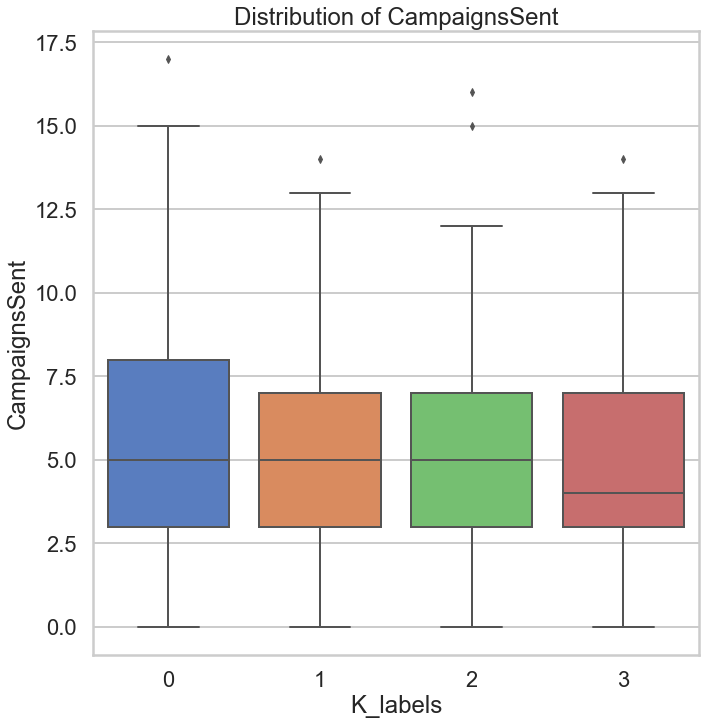

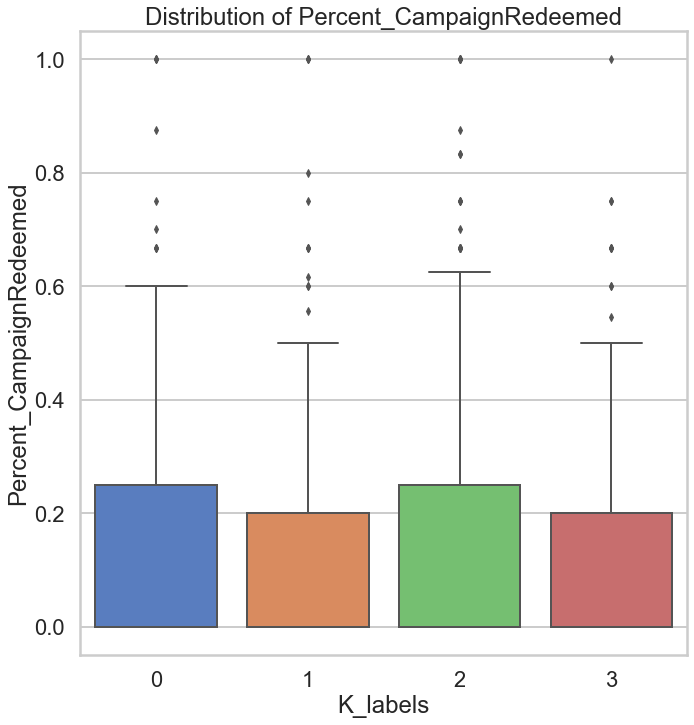

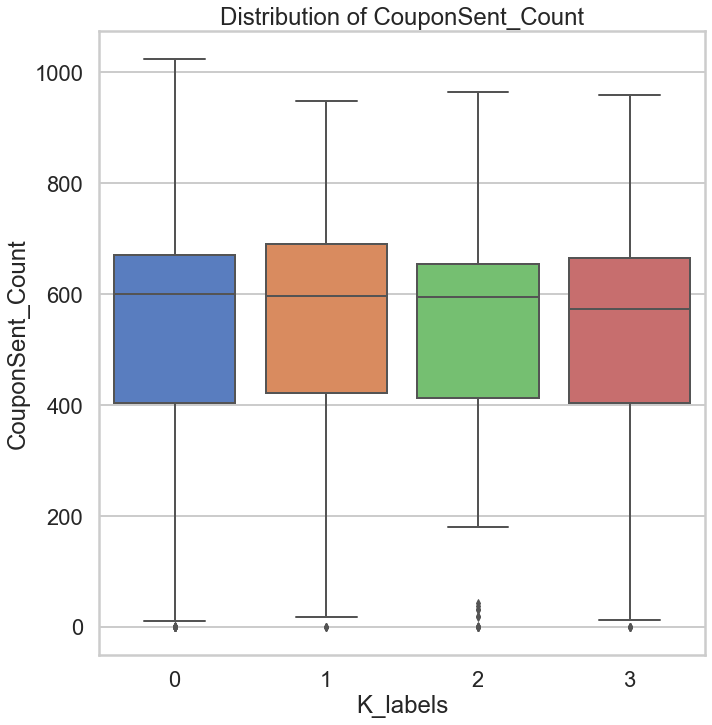

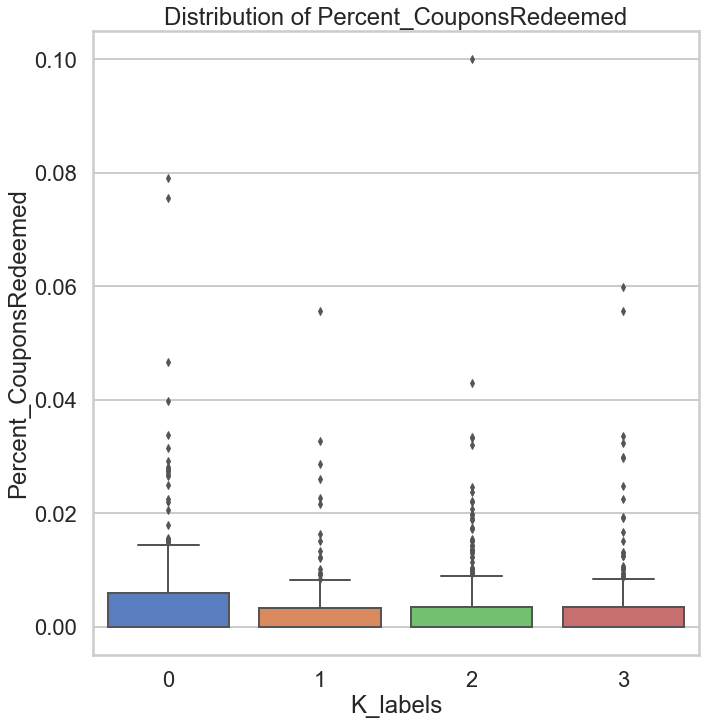

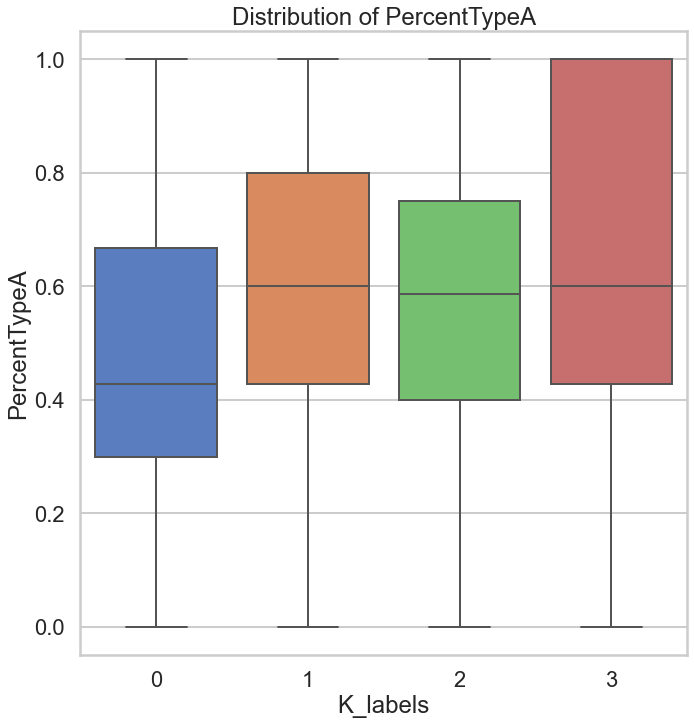

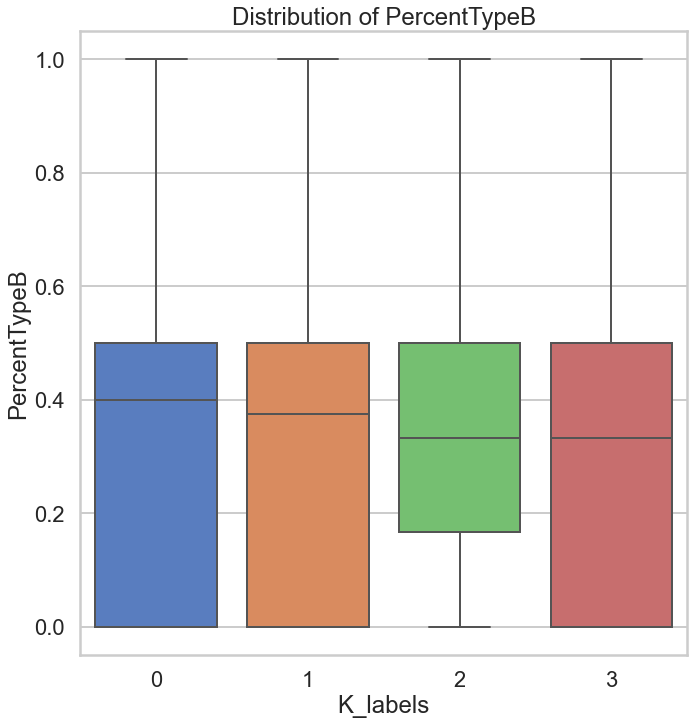

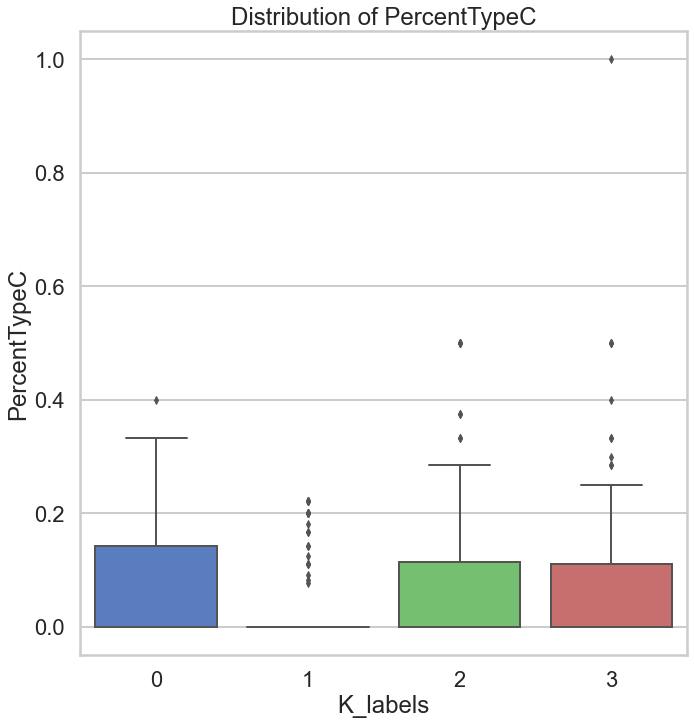

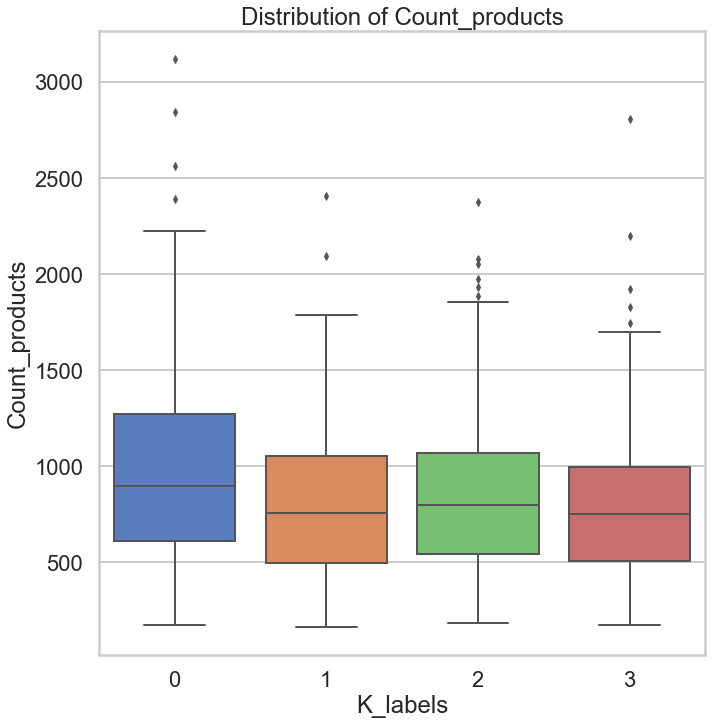

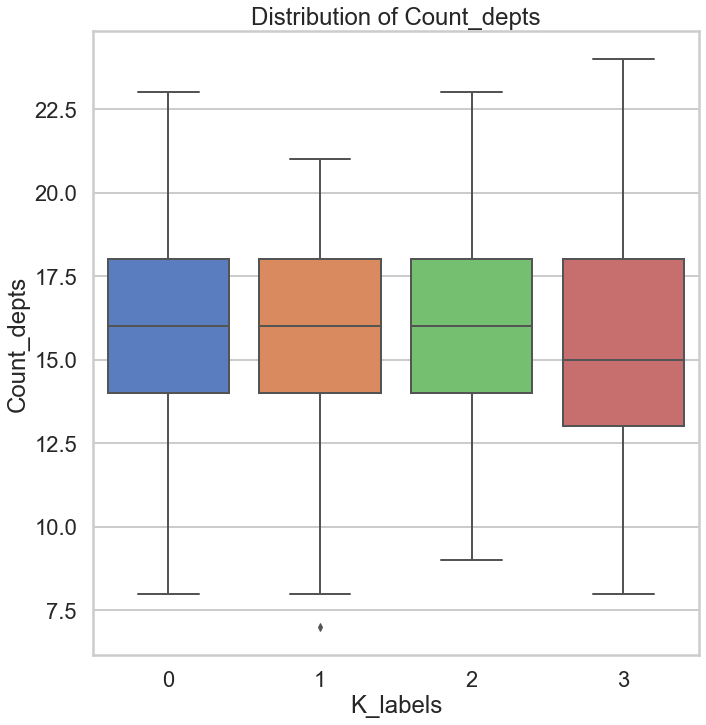

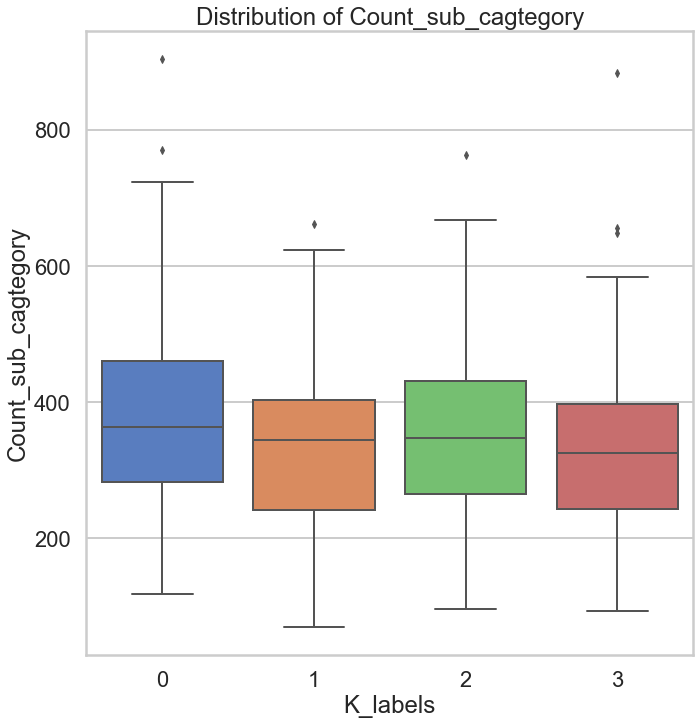

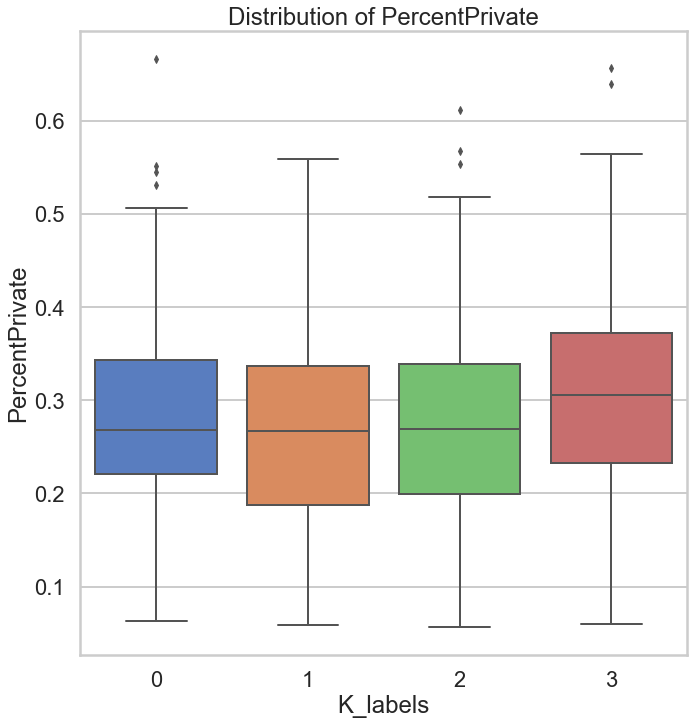

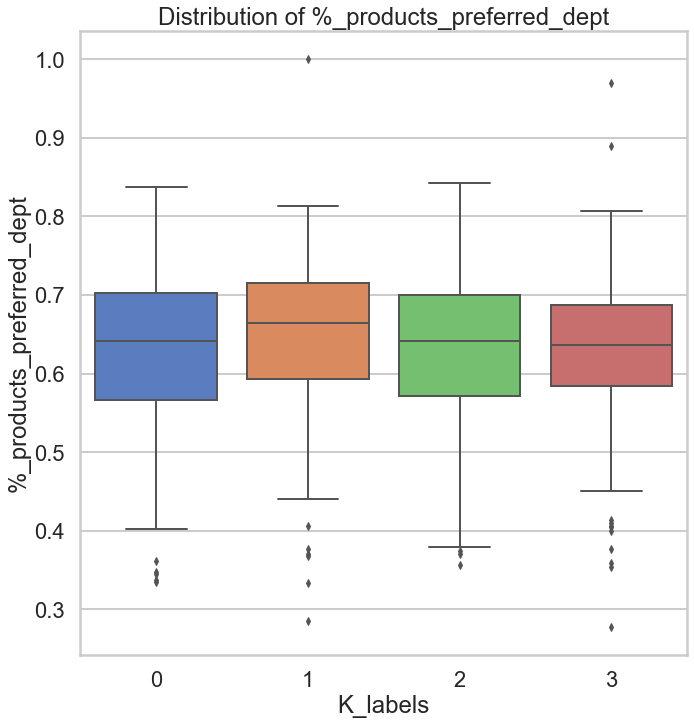

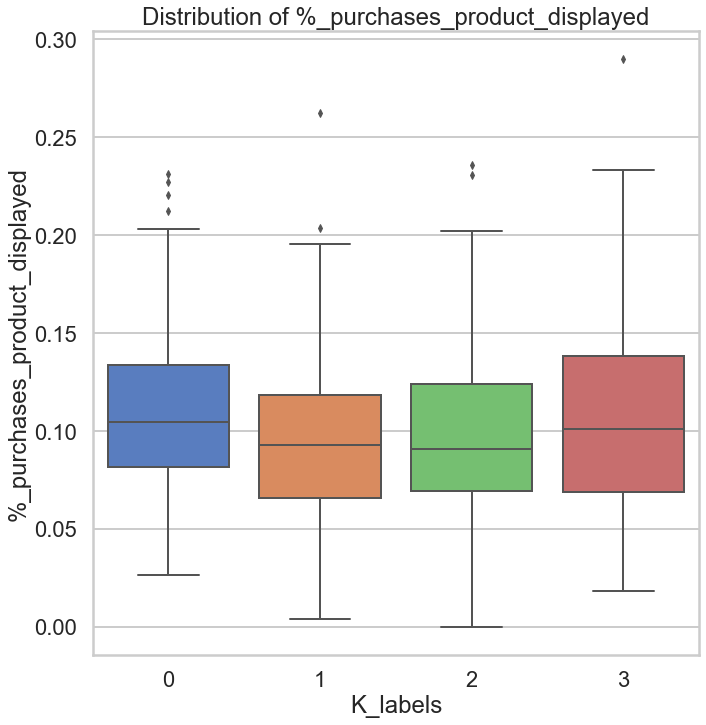

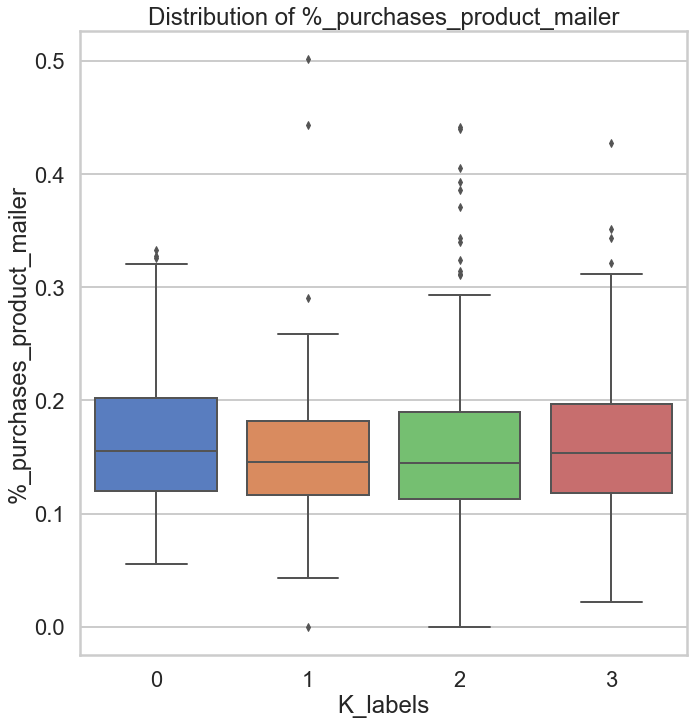

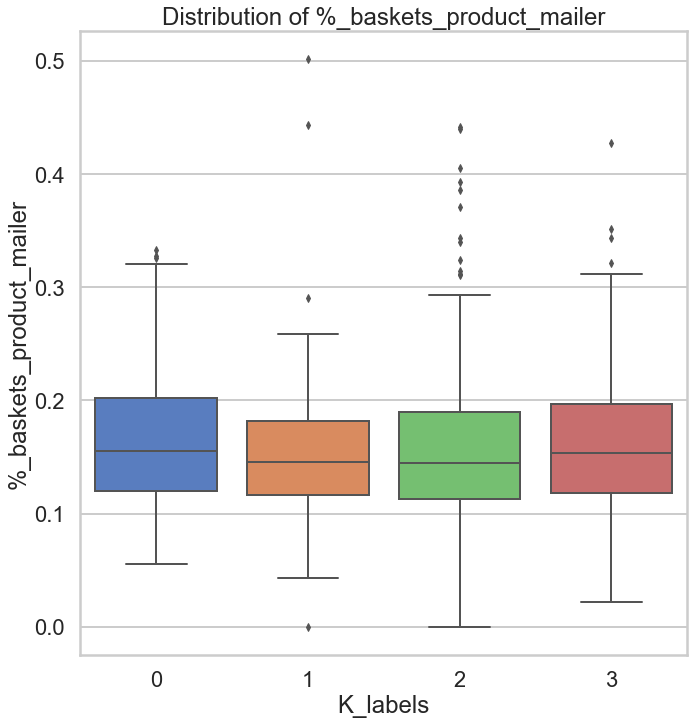

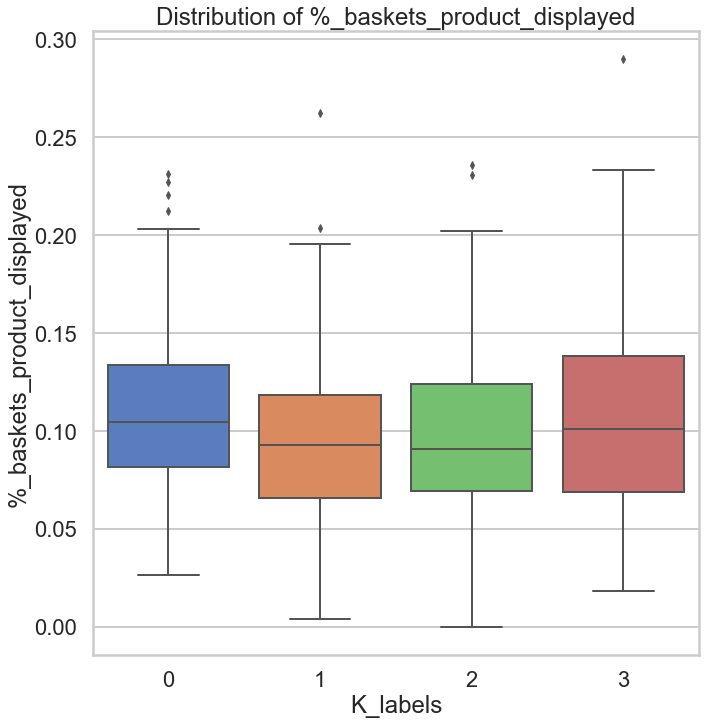

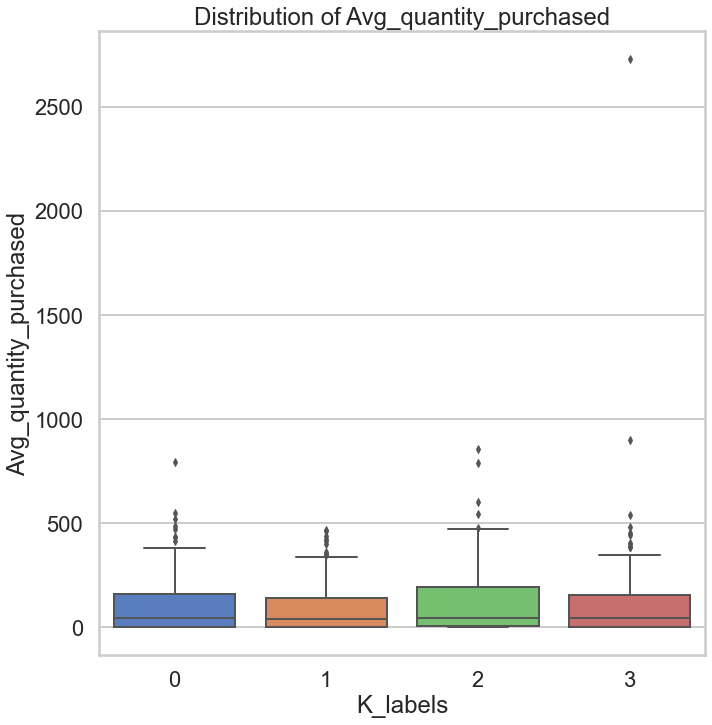

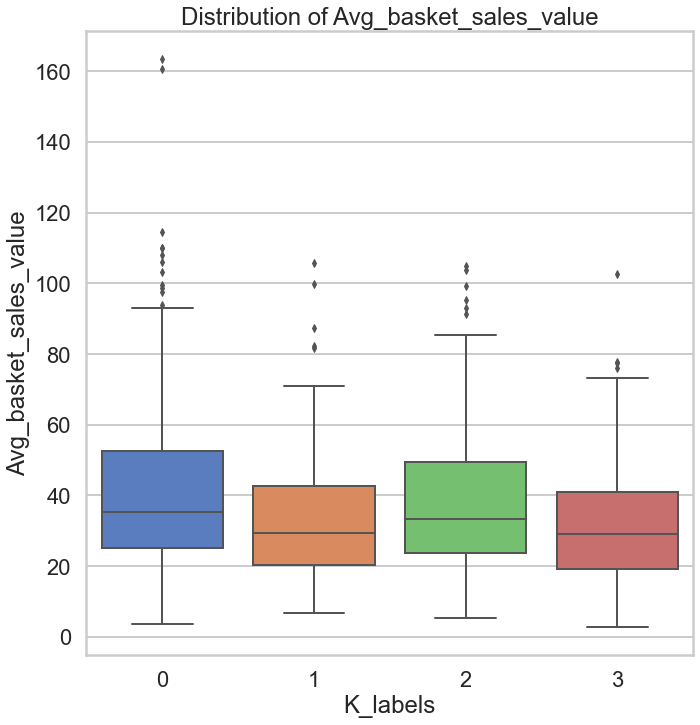

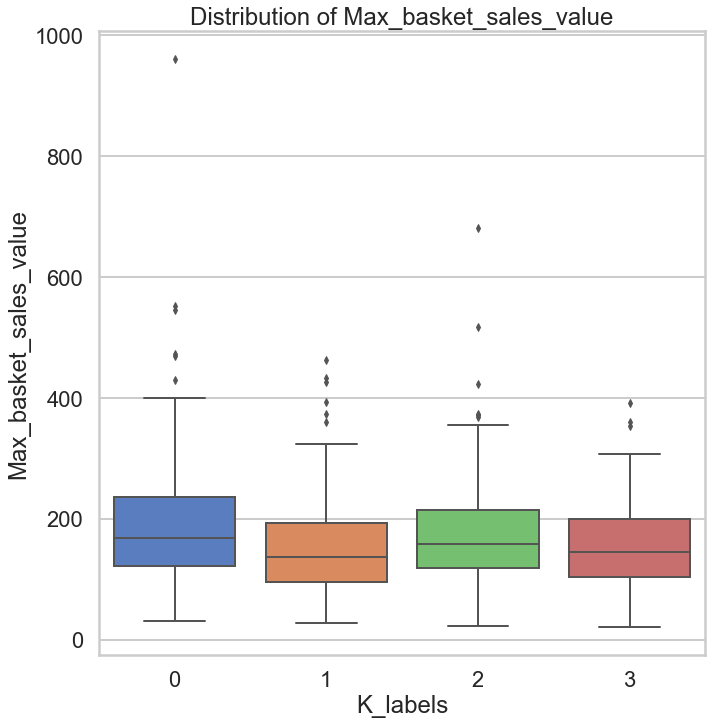

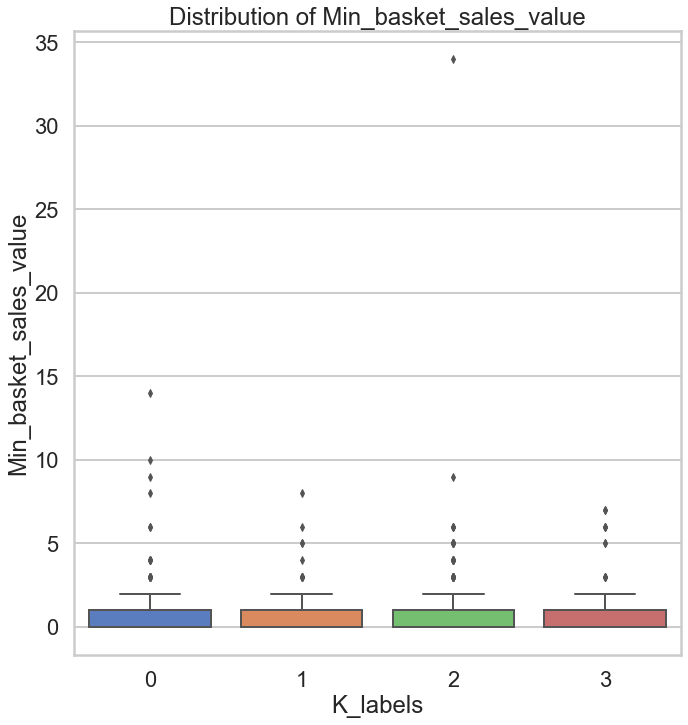

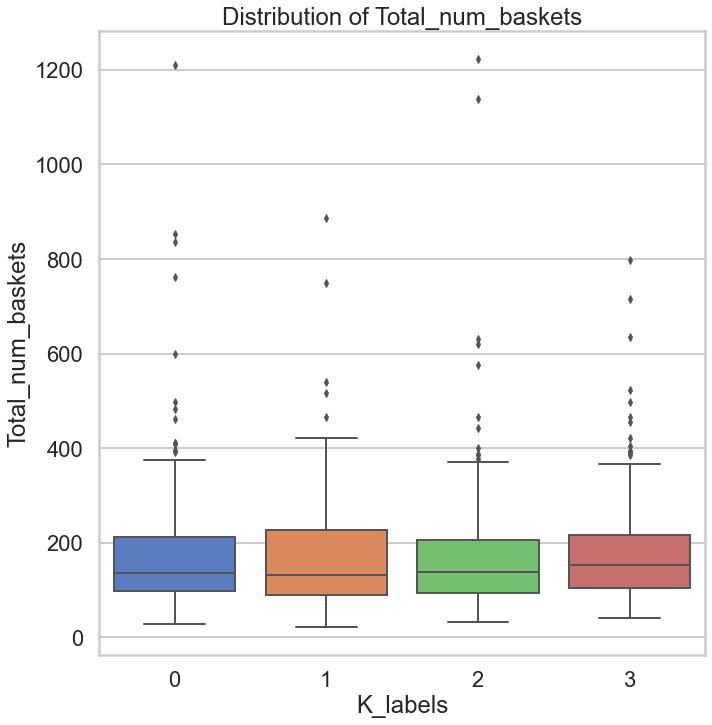

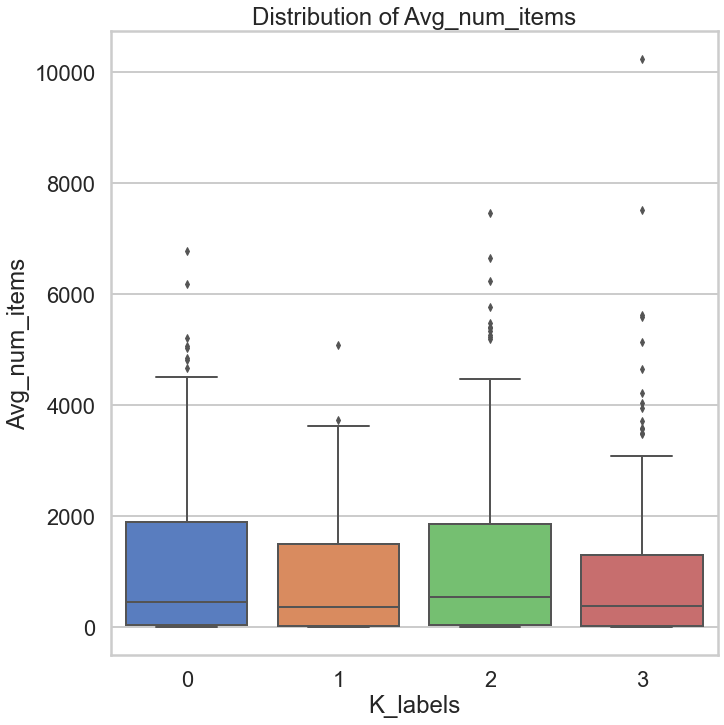

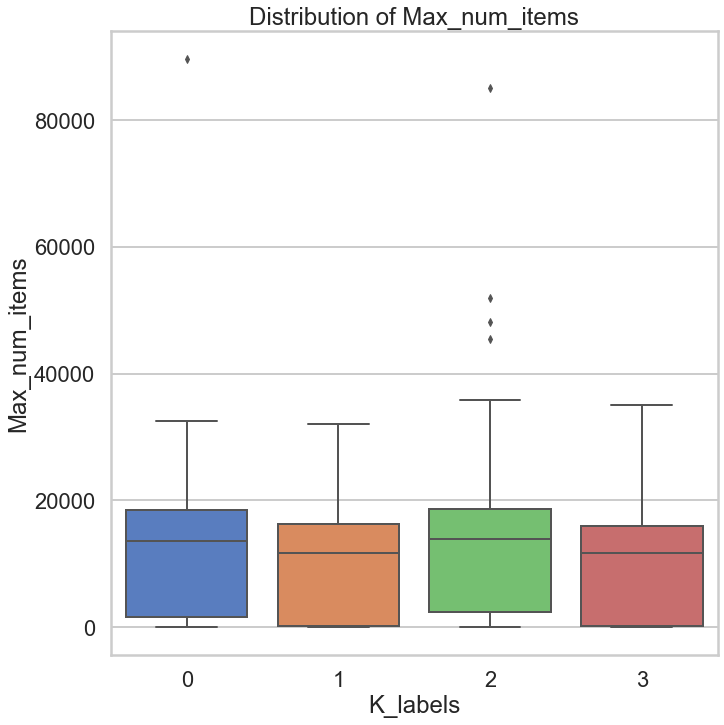

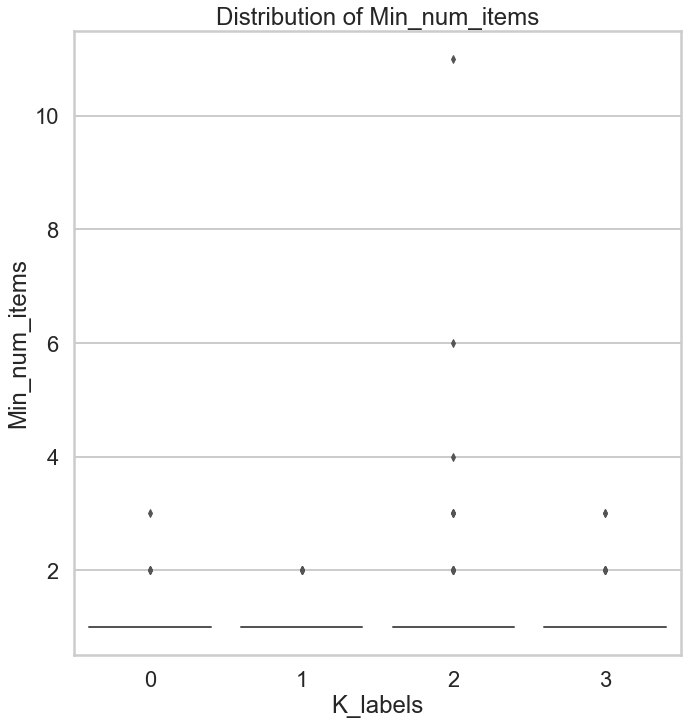

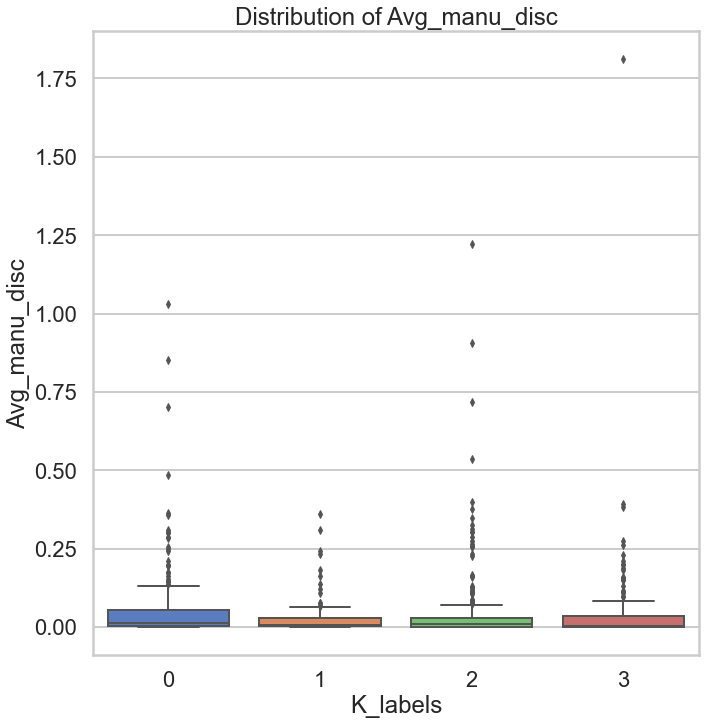

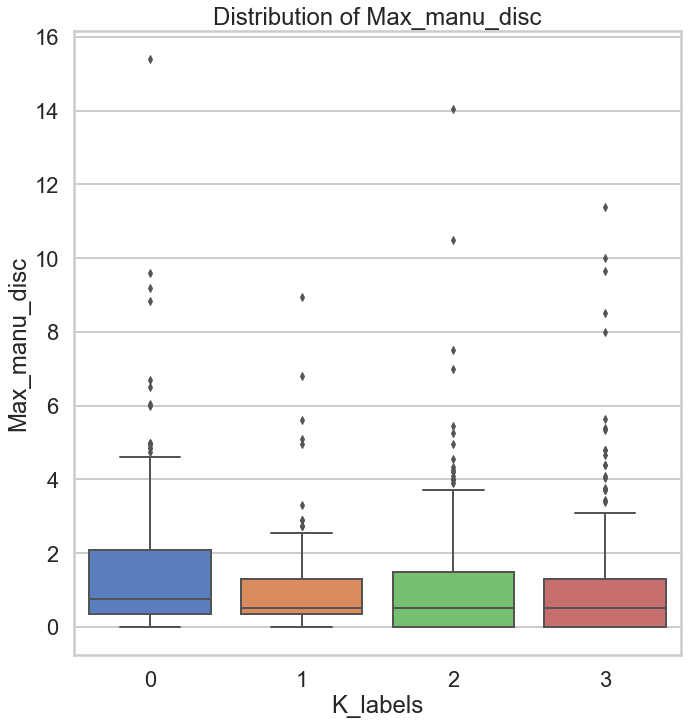

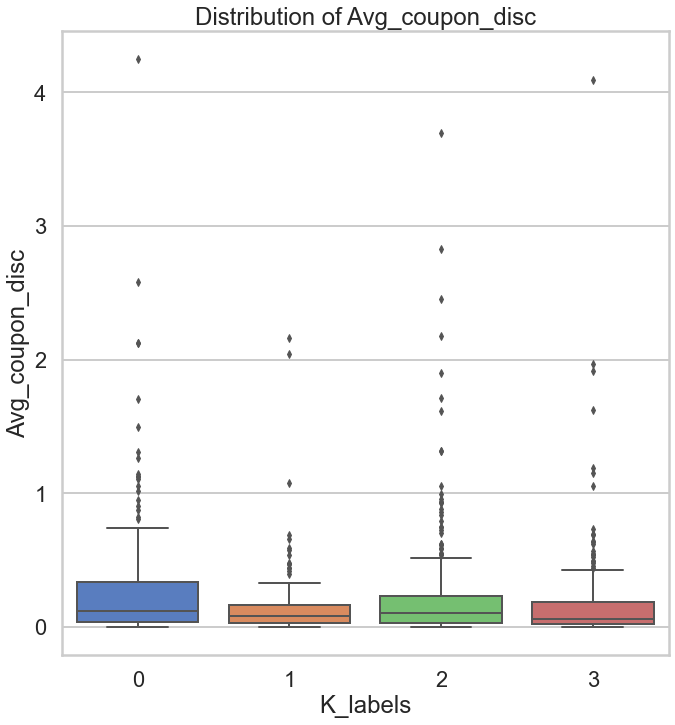

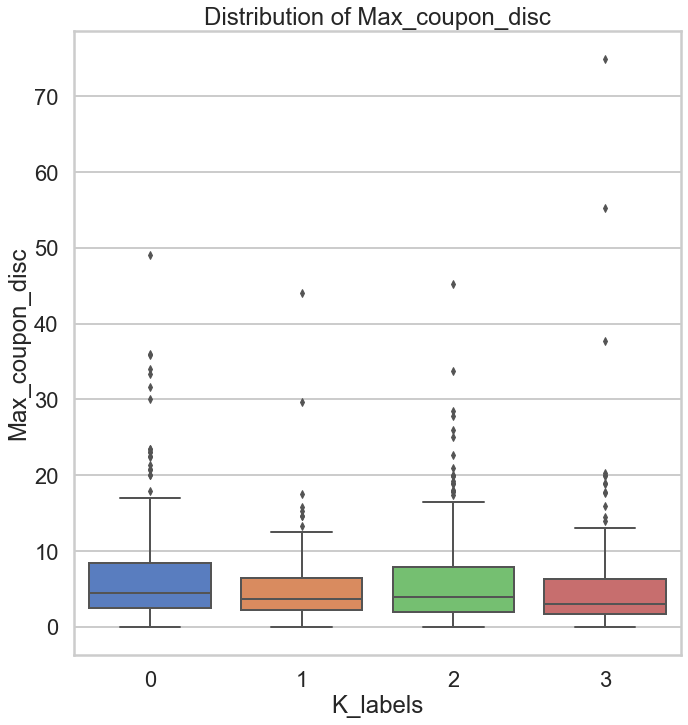

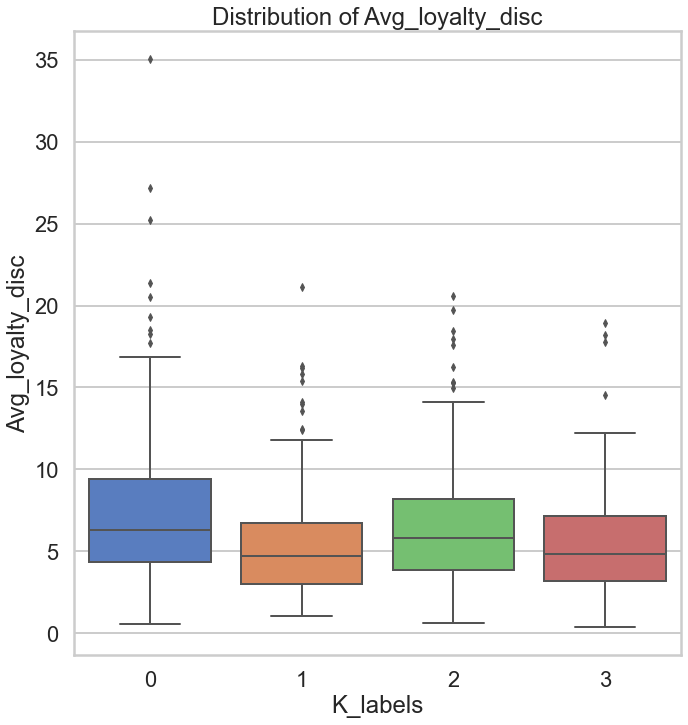

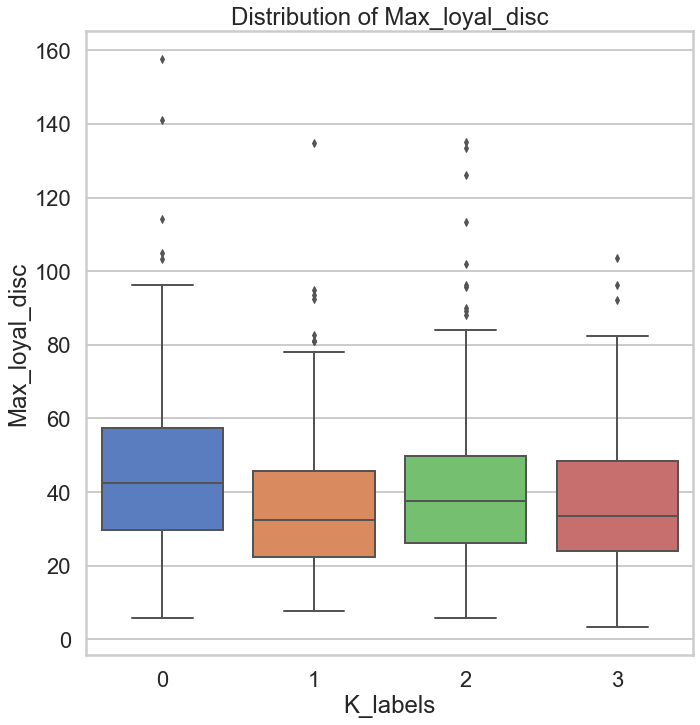

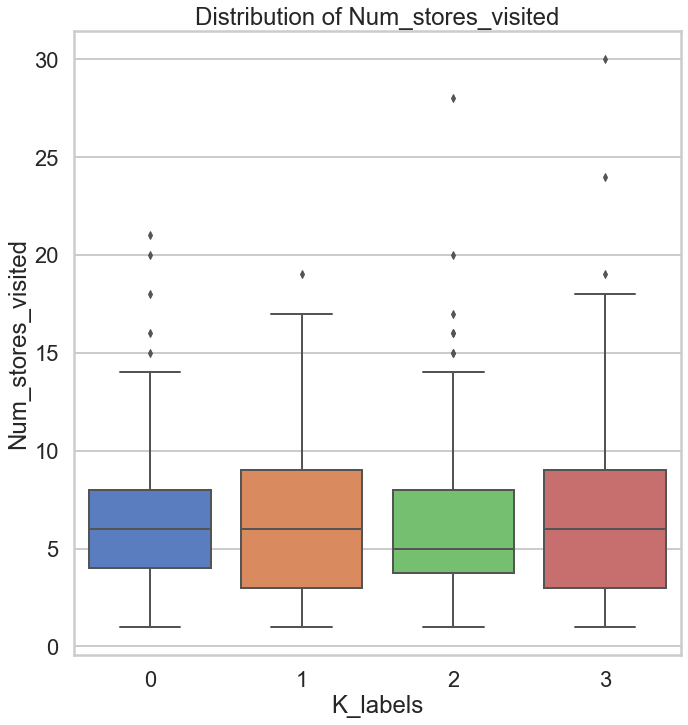

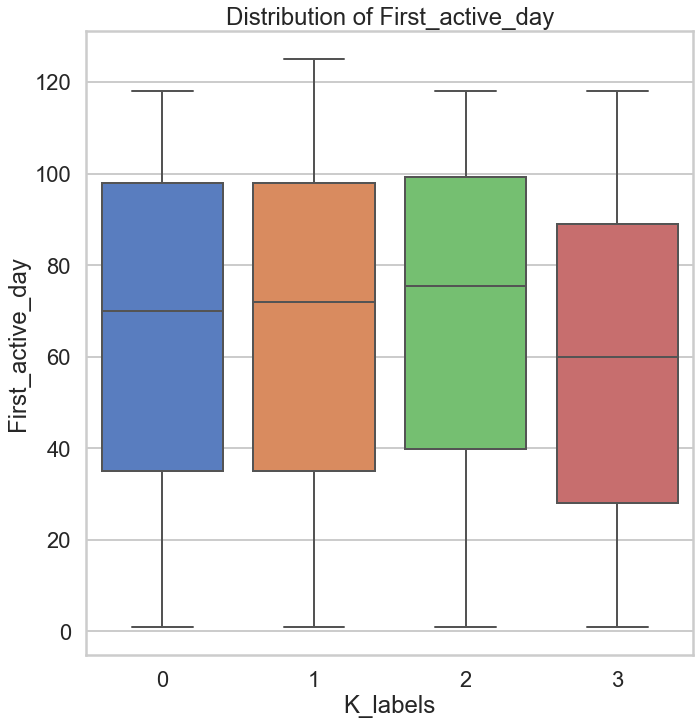

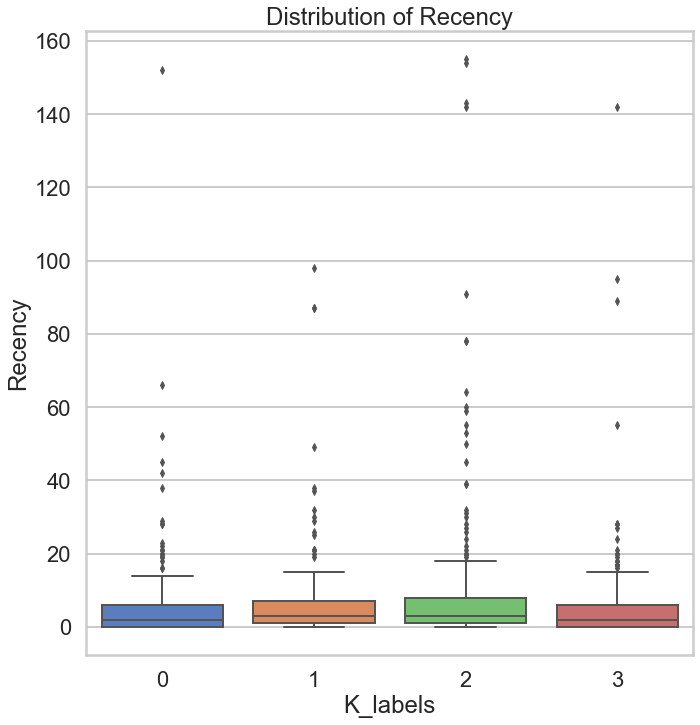

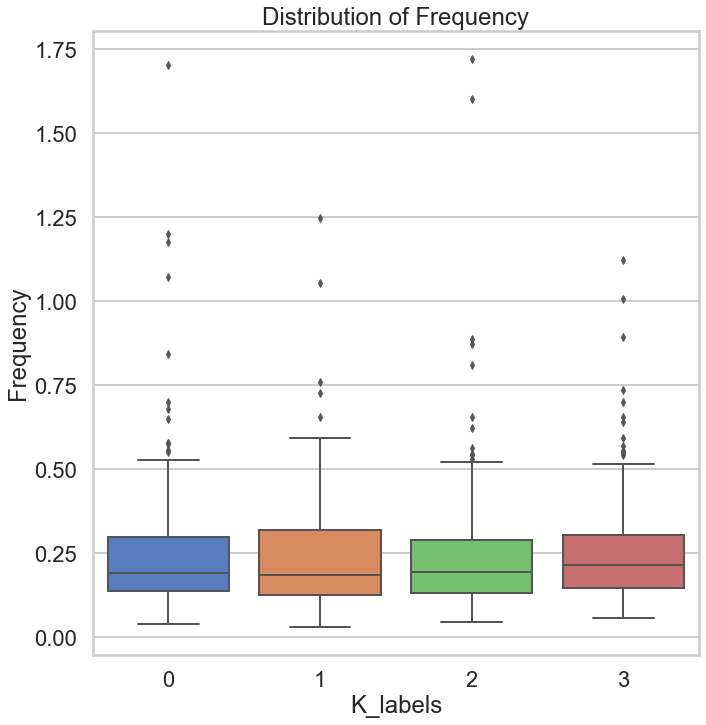

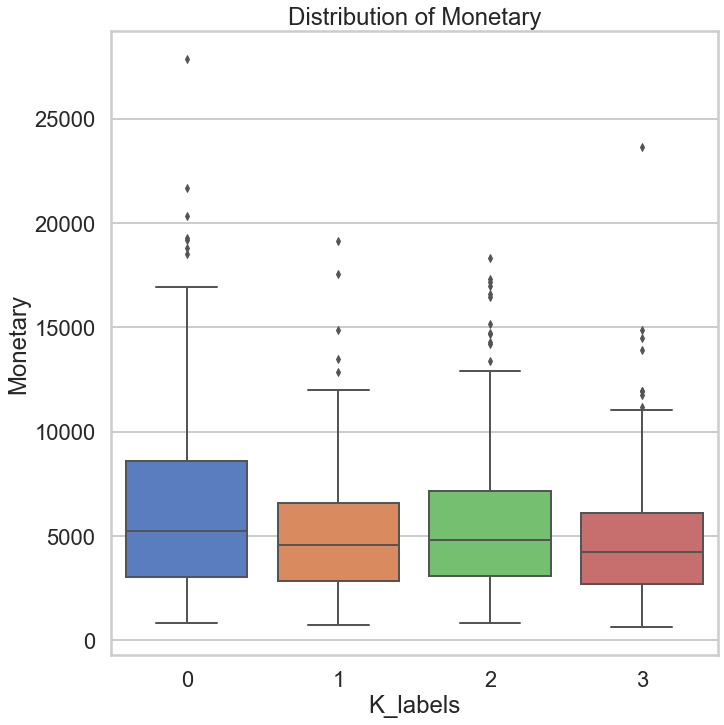

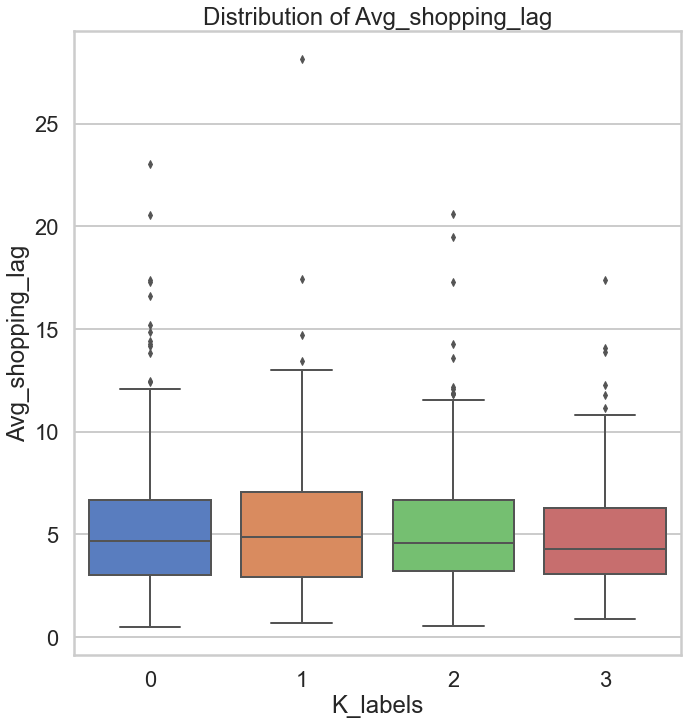

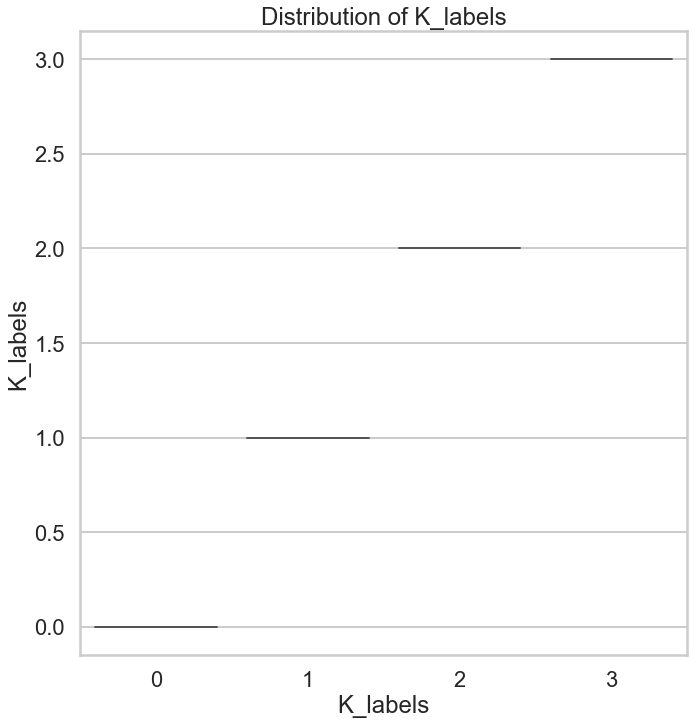

In [16]:
for item in k_num.columns:
    fig, ax1 = plt.subplots(1,1, figsize=(10,10))
    fig.tight_layout()
    sns.boxplot(x='K_labels', y=item, data=k_num, ax=ax1, palette='muted', linewidth=2, order=klabels)
    ax1.set_title('Distribution of {0}'.format(item))

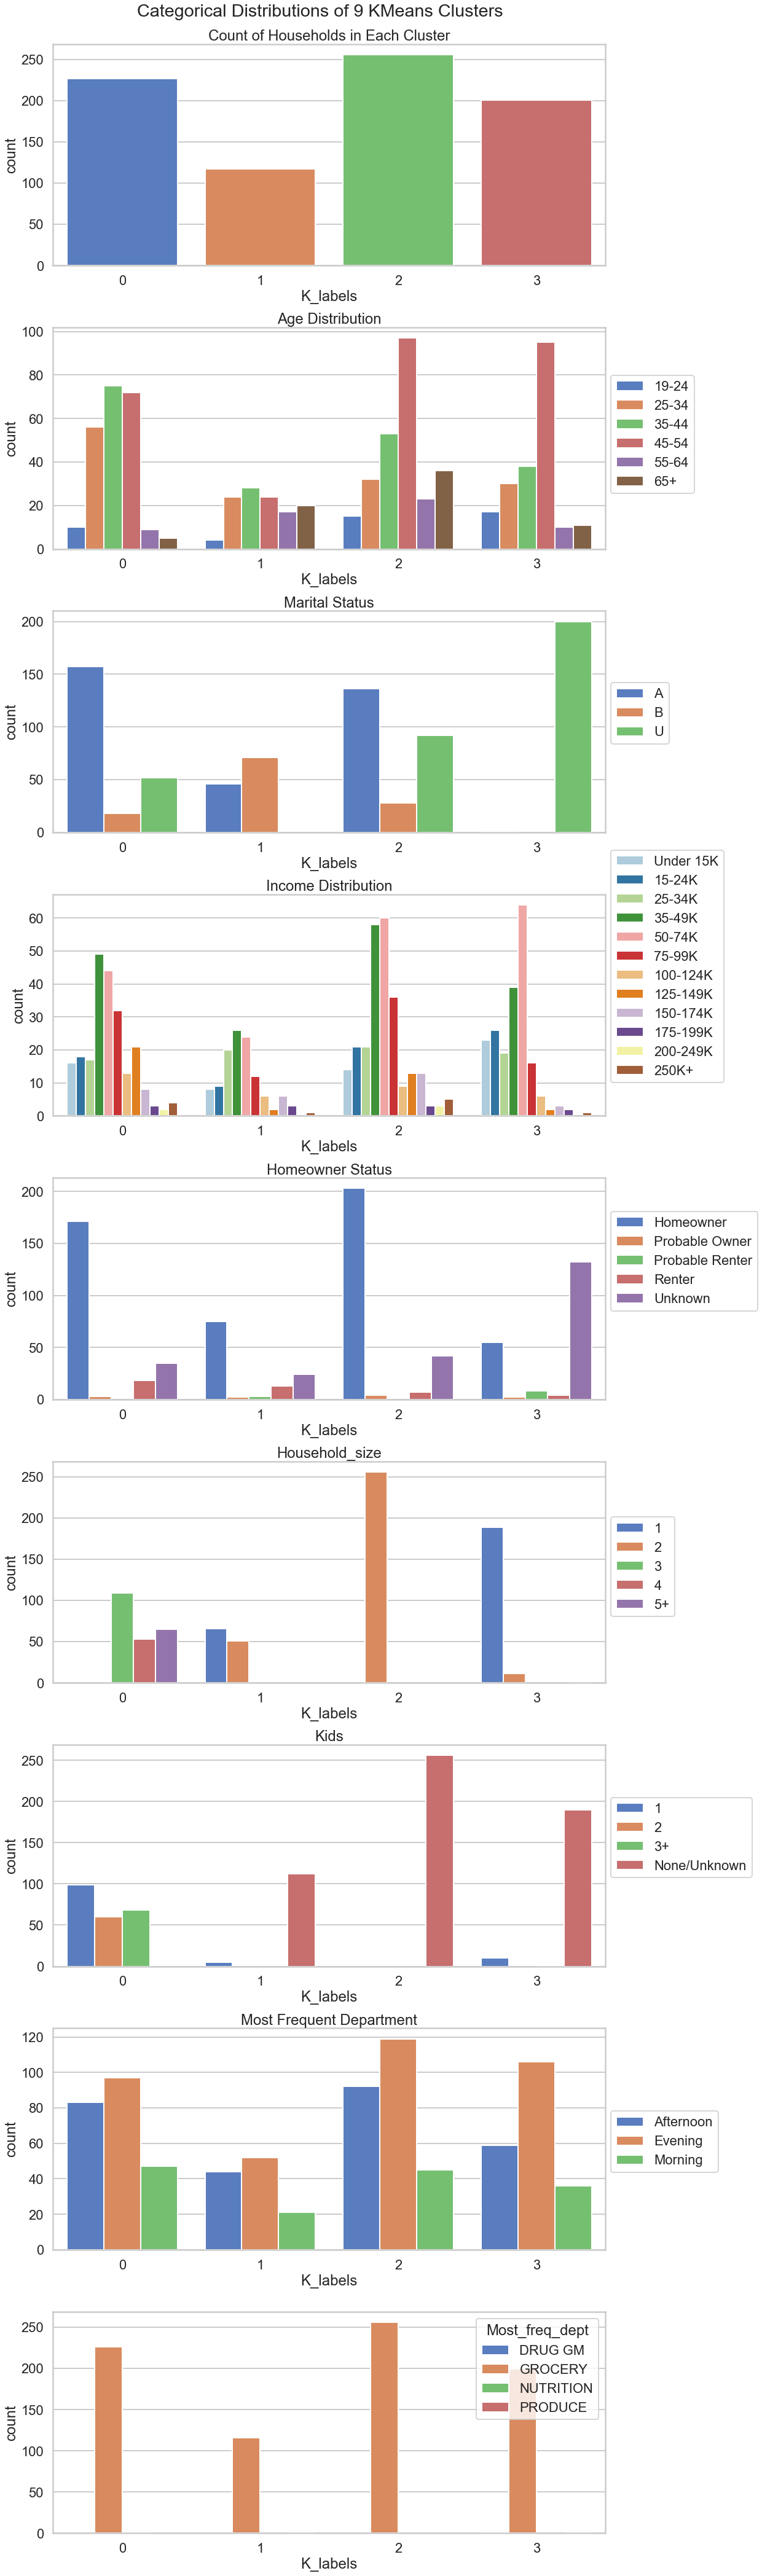

In [17]:
fig, ax = plt.subplots(8, 1, figsize=(15, 60))
fig.tight_layout(pad=2.5)
fig.subplots_adjust(top=0.96)
fig.suptitle('Categorical Distributions of 9 KMeans Clusters', y=0.975)
sns.countplot(x='K_labels', data=results, palette='muted', linewidth=2, ax=ax[0])
ax[0].set_title('Count of Households in Each Cluster')
sns.countplot(x='K_labels', hue='Age', data=results, order=klabels, palette='muted', linewidth=2, ax=ax[1],
             hue_order = np.sort(results.Age.unique()))
ax[1].set_title('Age Distribution')
ax[1].legend(loc=(1.01,0.25))

sns.countplot(x='K_labels', hue='Marital_status', data=results, order=klabels, palette='muted', linewidth=2, 
              ax=ax[2], hue_order = np.sort(results.Marital_status.unique()))
ax[2].set_title('Marital Status')
ax[2].legend(loc=(1.01,0.4))

sns.countplot(x='K_labels', hue='Income', data=results, order=klabels, palette='Paired', linewidth=2, ax=ax[3], 
             hue_order= [ 'Under 15K', '15-24K', '25-34K','35-49K', '50-74K', '75-99K', '100-124K', '125-149K', 
                         '150-174K', '175-199K','200-249K', '250K+'])
ax[3].set_title('Income Distribution')
ax[3].legend(loc=(1.01,0.15))

sns.countplot(x='K_labels', hue='Homeowner_status', data=results, order=klabels, palette='muted', linewidth=2, 
              ax=ax[4], hue_order = np.sort(results.Homeowner_status.unique()))
ax[4].set_title('Homeowner Status')
ax[4].legend(loc=(1.01,0.4))

sns.countplot(x='K_labels', hue='Household_size', data=results, order=klabels, palette='muted', linewidth=2, 
              ax=ax[5], hue_order = np.sort(results.Household_size.unique()))
ax[5].set_title('Household_size')
ax[5].legend(loc=(1.01,0.3))

sns.countplot(x='K_labels', hue='Kids', data=results, order=klabels, palette='muted', linewidth=2, ax=ax[6],
             hue_order = np.sort(results.Kids.unique()))
ax[6].set_title('Kids')
ax[6].legend(loc=(1.01,0.4))

sns.countplot(x='K_labels', hue='Time', data=results, order=klabels, palette='muted', linewidth=2, ax=ax[7], 
             hue_order=np.sort(results.Time.unique()));
ax[7].set_title('Time')
ax[7].legend(loc=(1.01,0.35));

After iterating over various numbers of clusters, passing 6 cluster centers to the K-means algorithm provided the most distinct demographic clusters while also showing the largest degree of difference in transaction behavior. 

However, both clusters 0 and 3, as well as 4 and 5, showed remarkable similarity in terms of both demographic makeup and transaction behavior so I'm going to combine those clusters for the purpose of customer segment analysis.   This structure is not recreated when passing 4 clusters to the K-means algorithm, but rather blends all the clusters together so that there is little difference between them.  

### Agglomerative Cluster Analysis

In [18]:
# Creates a sorted list of cluster labels from Agglomerative algorithm 
alabels = results['A_labels'].unique()
alabels = list(np.sort(alabels))
alabels

[0, 1, 2]

In [19]:
a_num = results.select_dtypes(include=[np.number])
a_cat = results.select_dtypes(include = 'object')
a_num = a_num.drop(['Last_active_day', 'K_labels'], axis=1)

<ipython-input-20-63b8049ec36f>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots(1,1, figsize=(10,10))


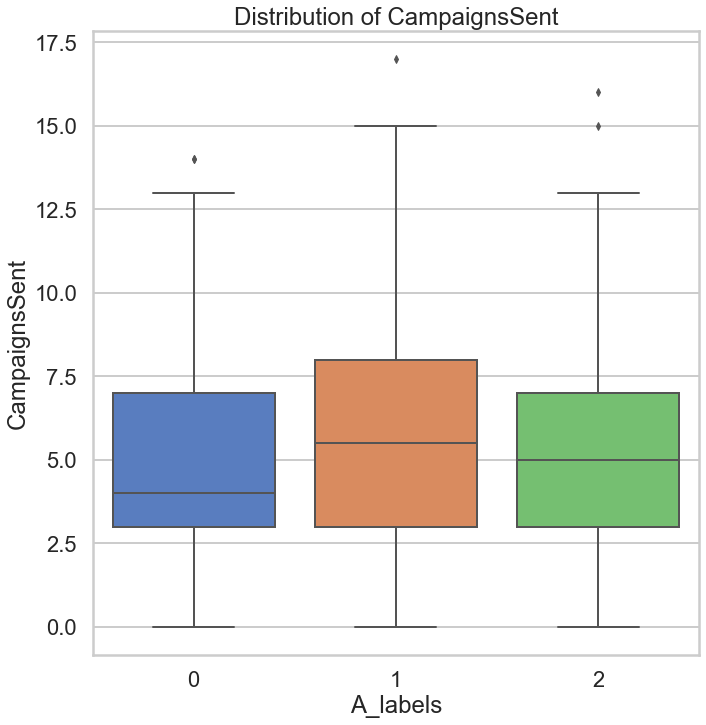

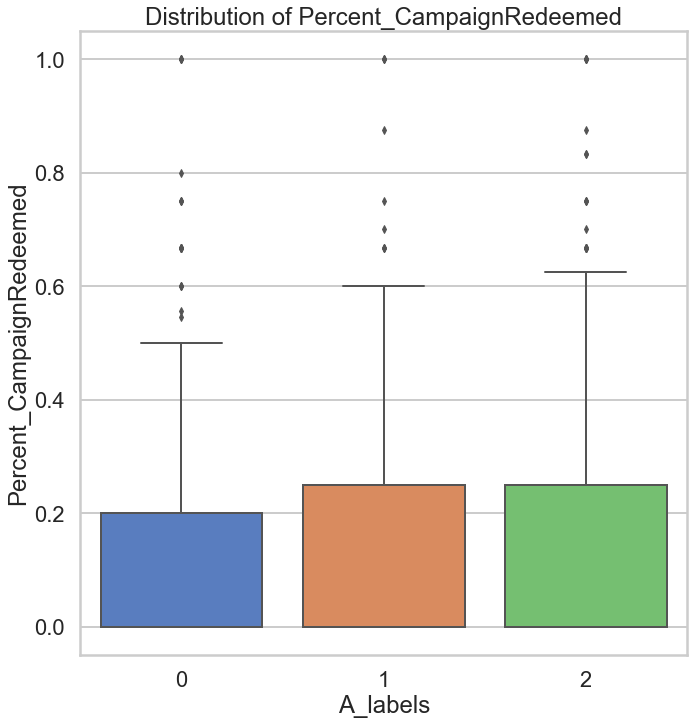

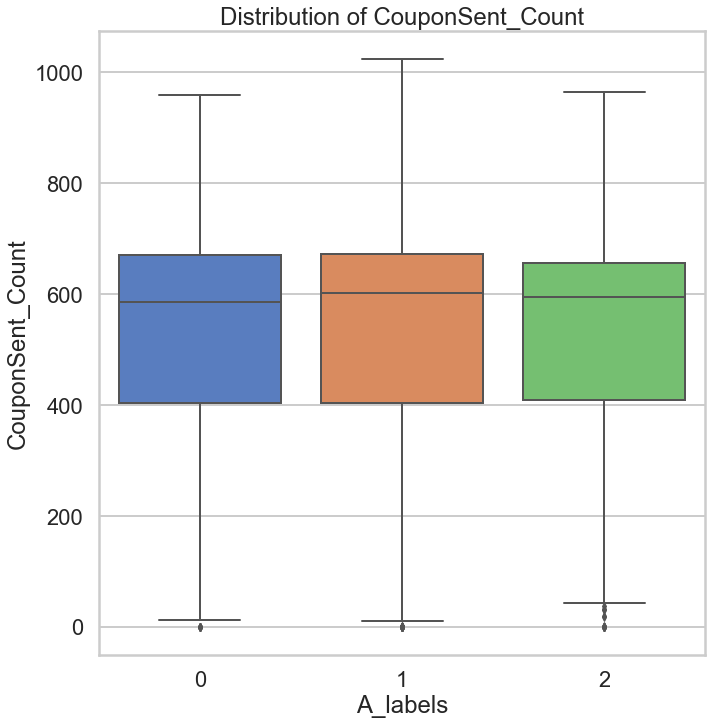

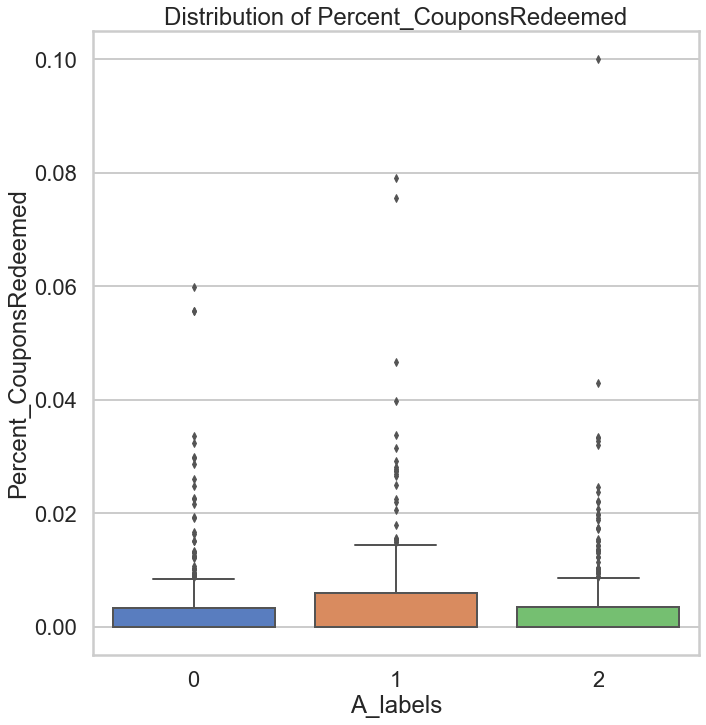

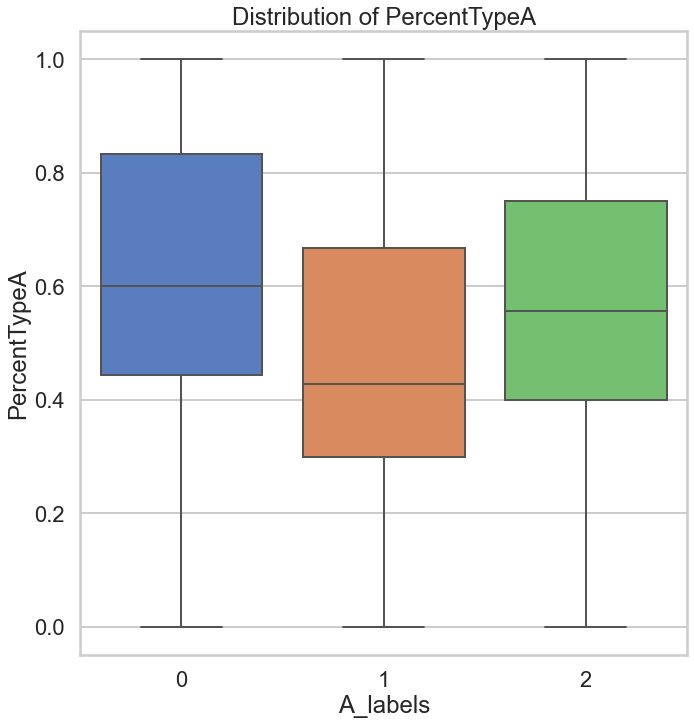

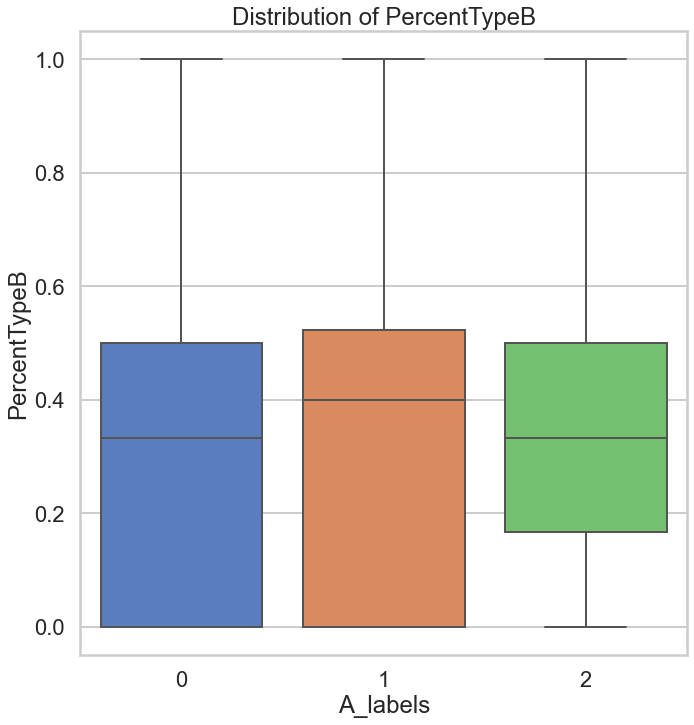

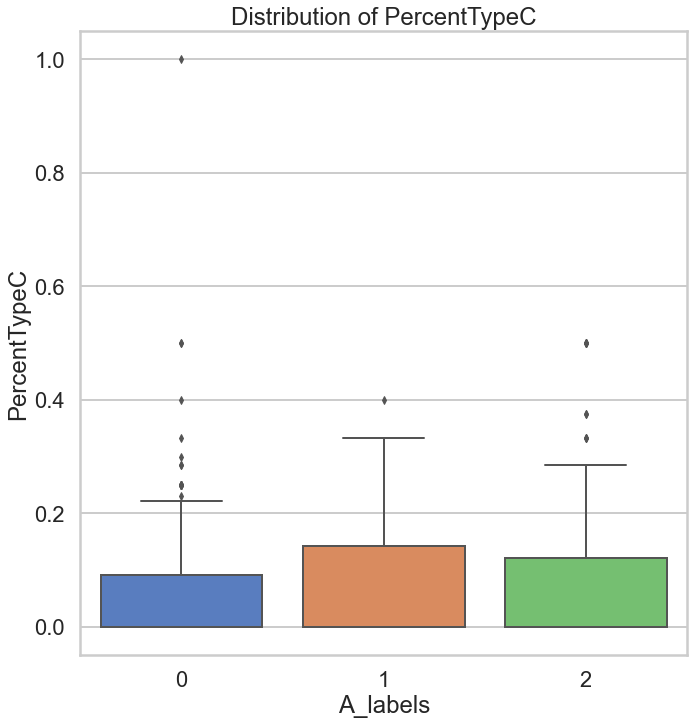

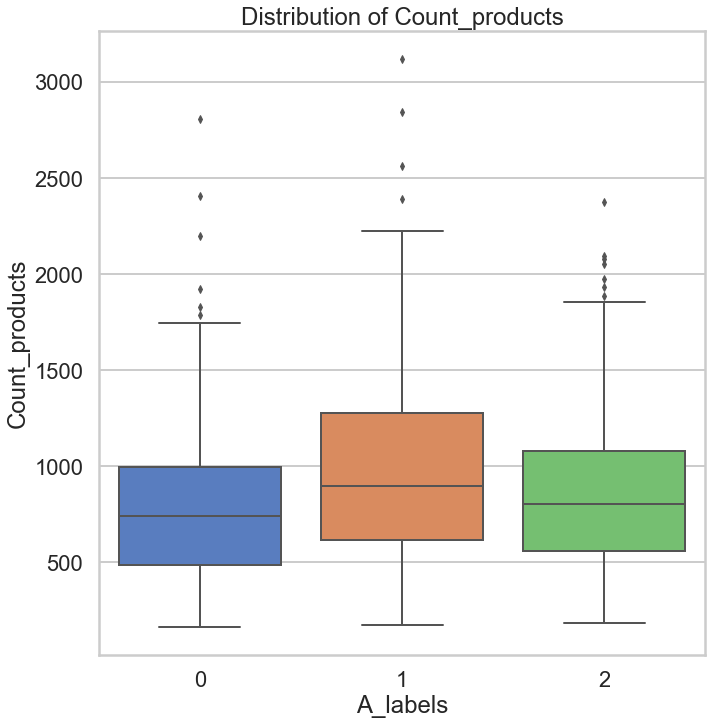

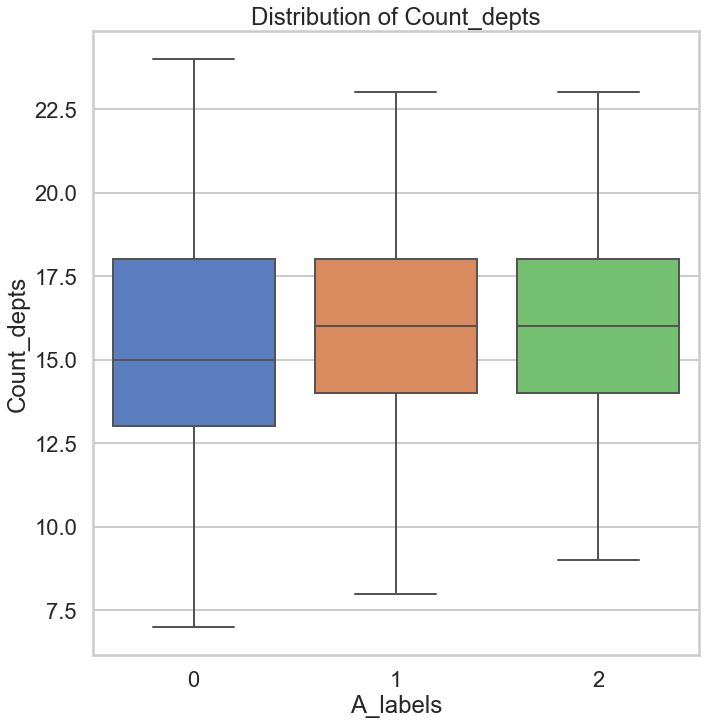

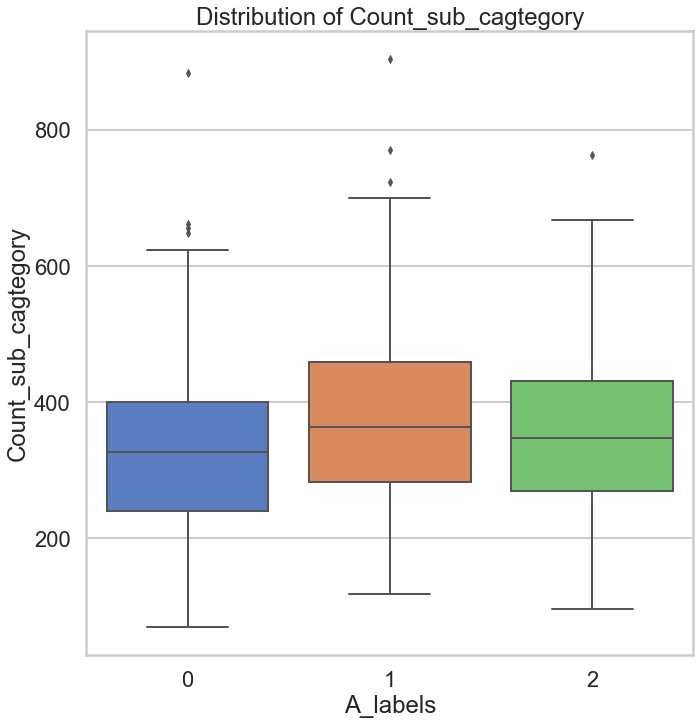

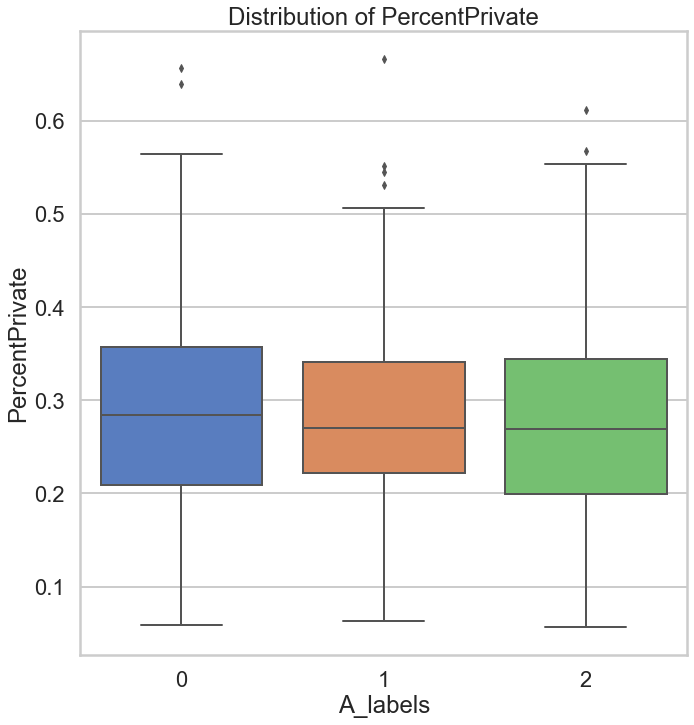

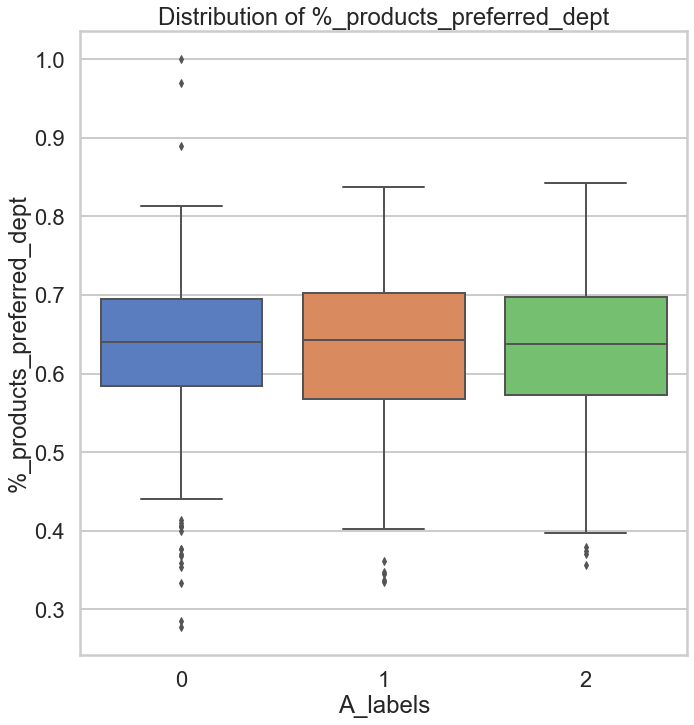

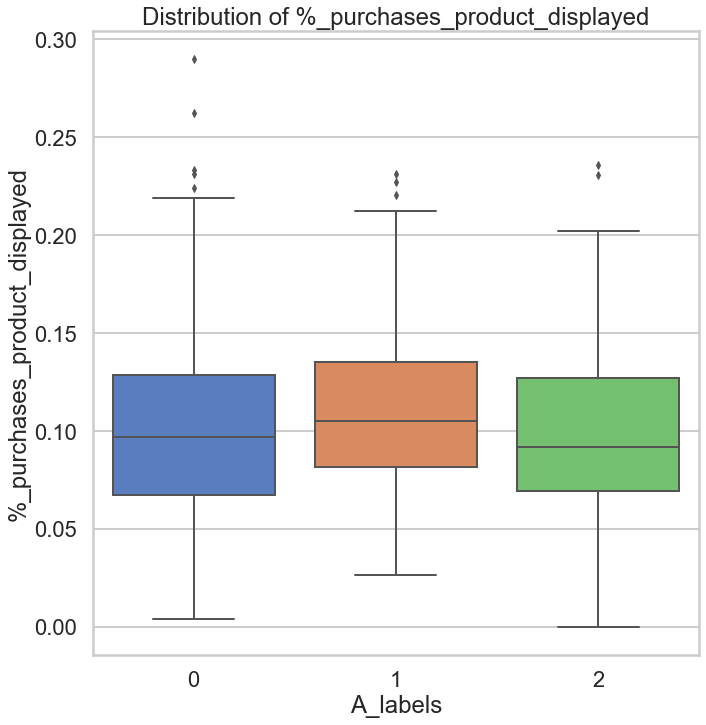

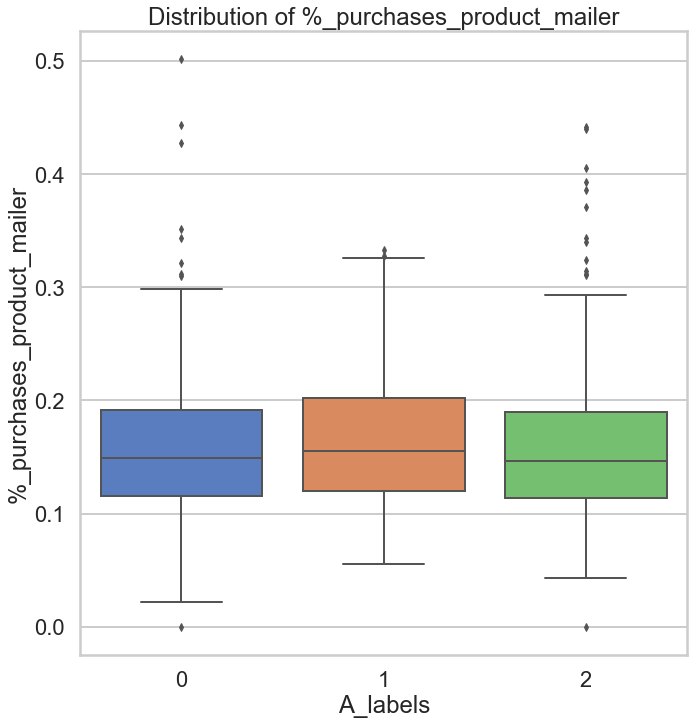

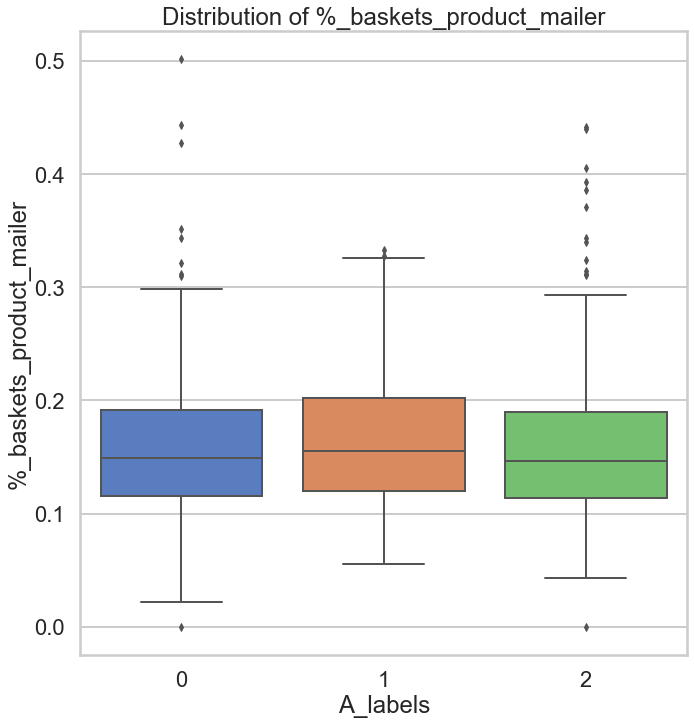

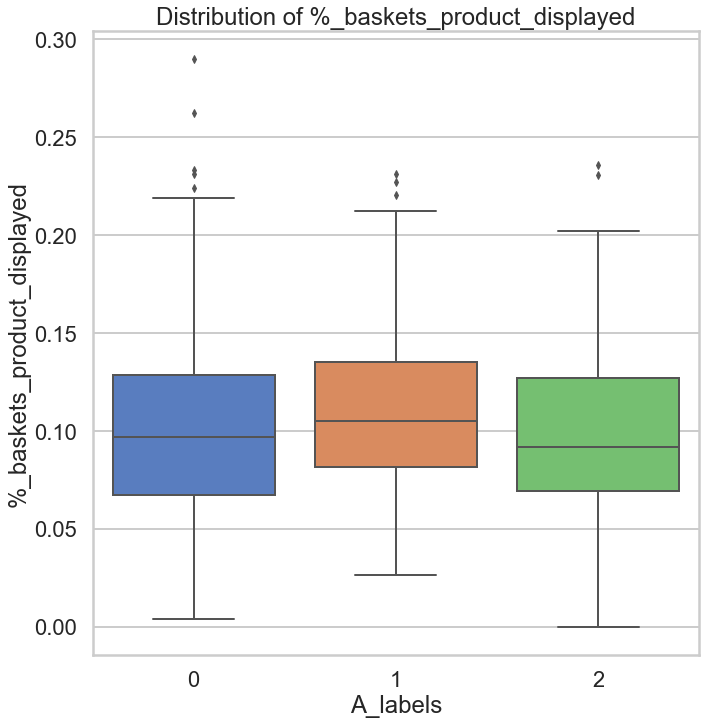

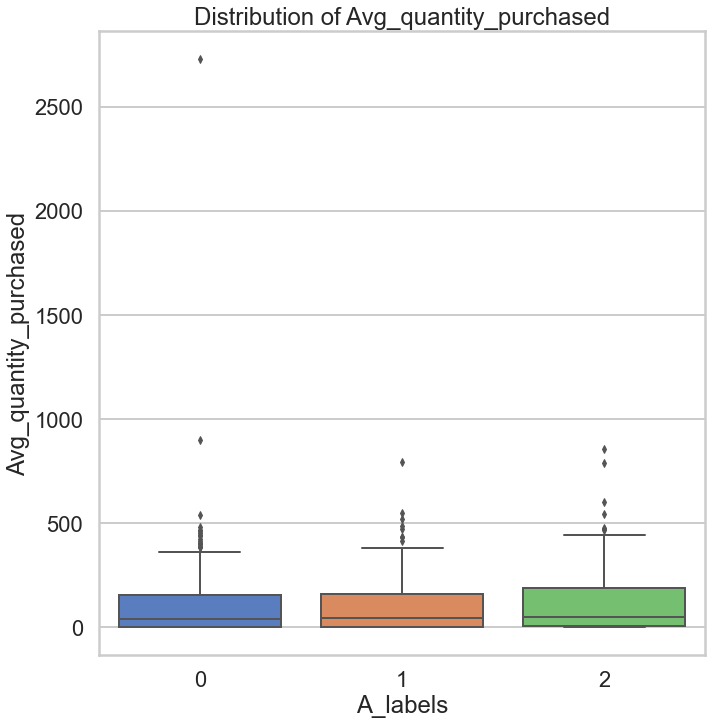

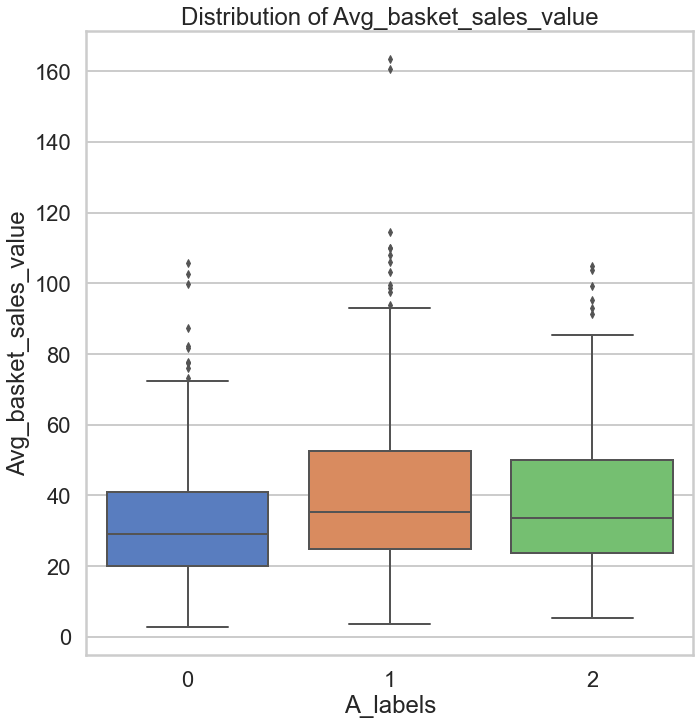

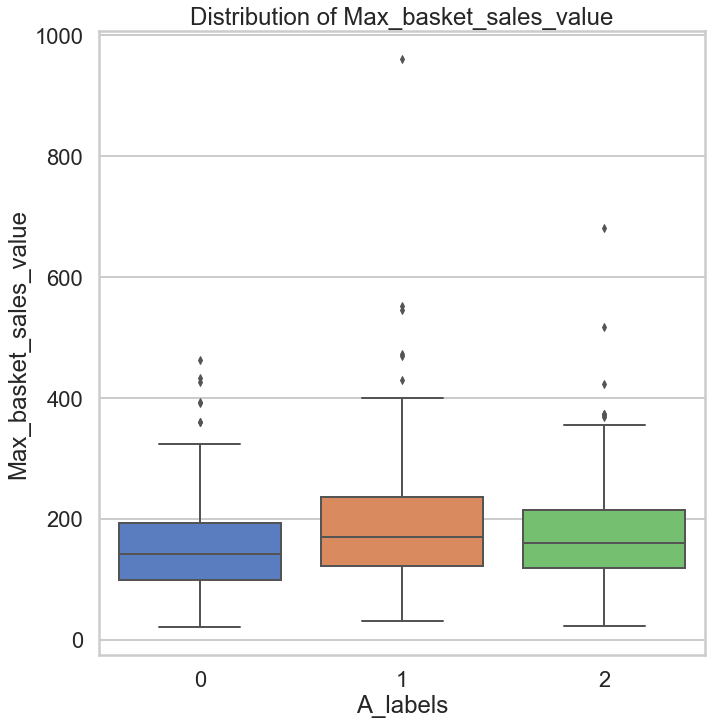

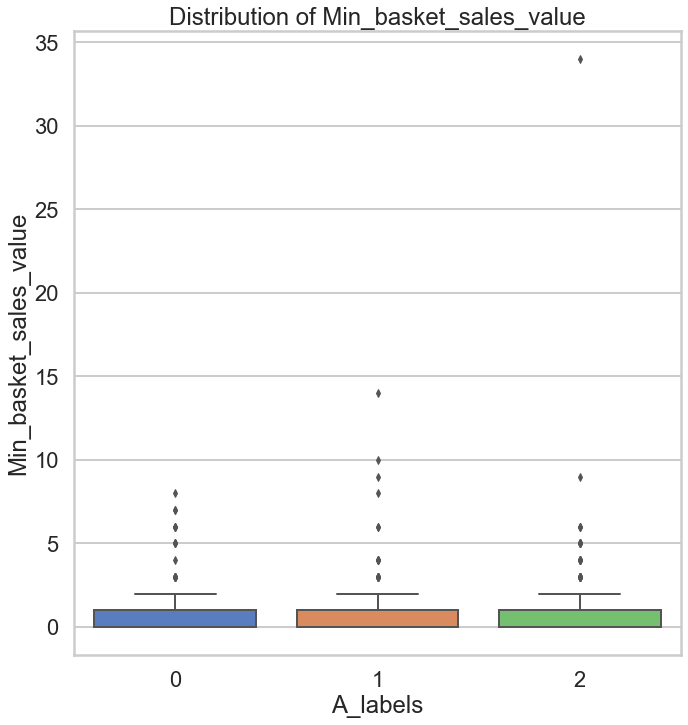

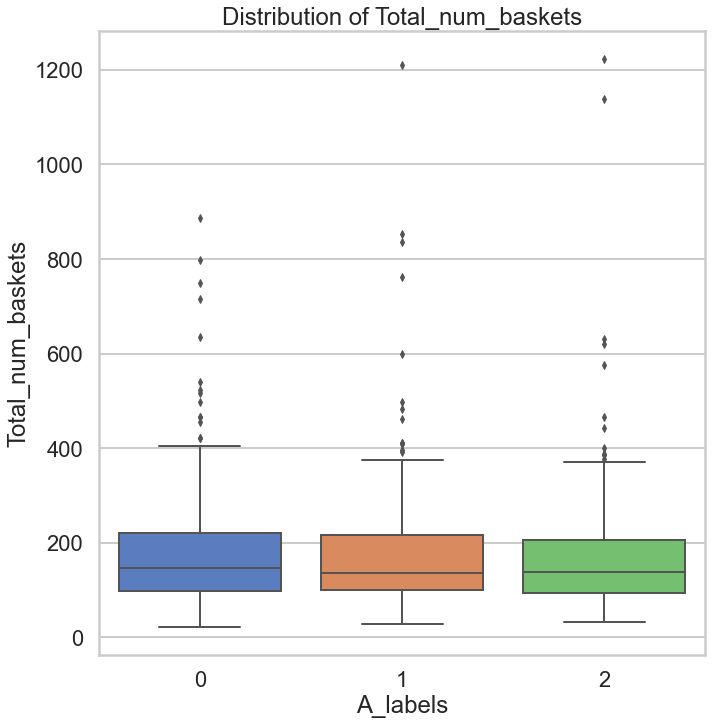

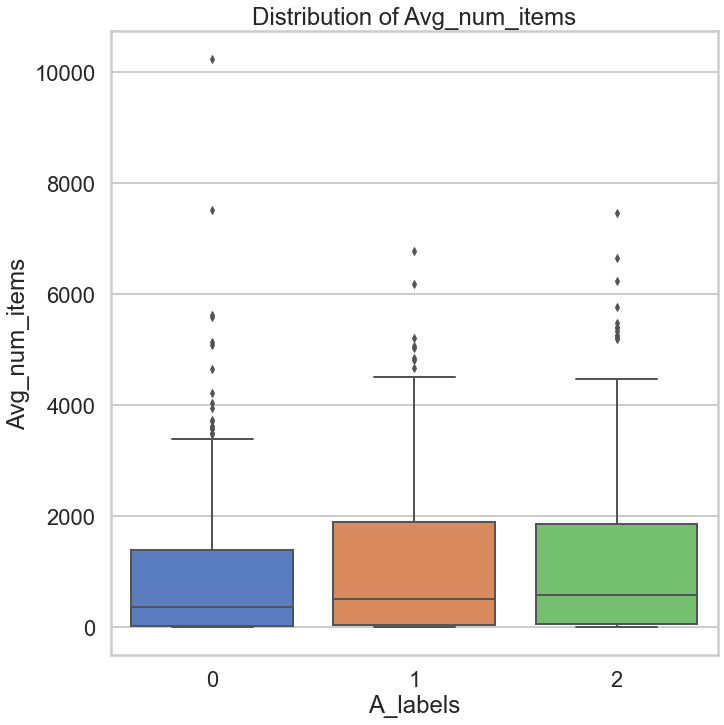

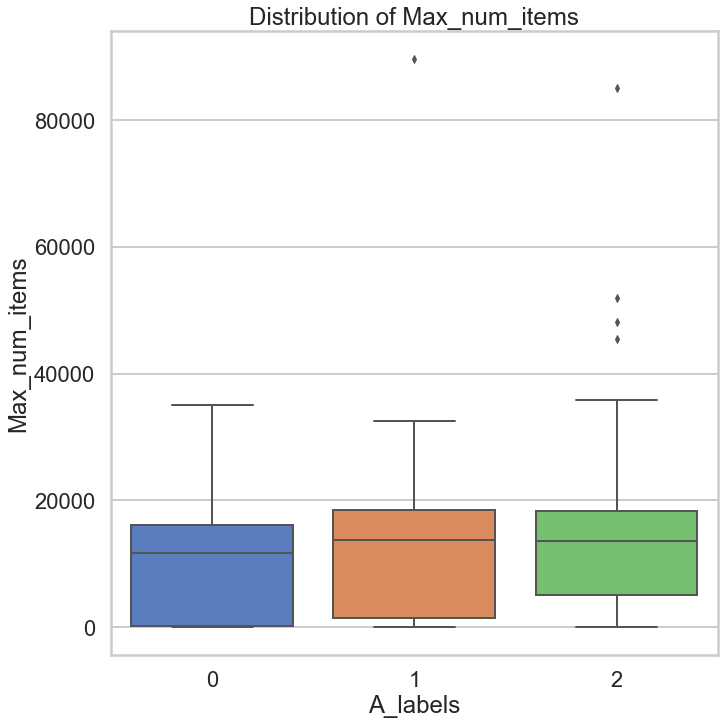

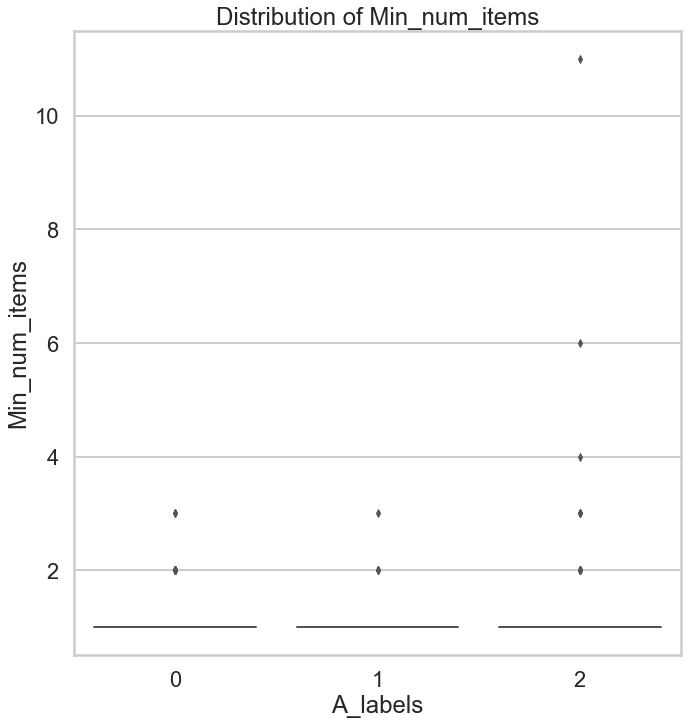

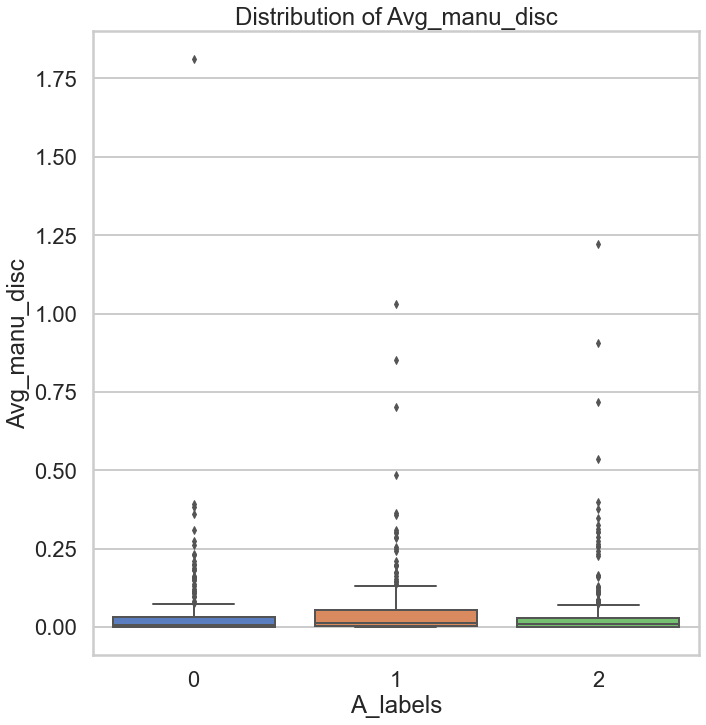

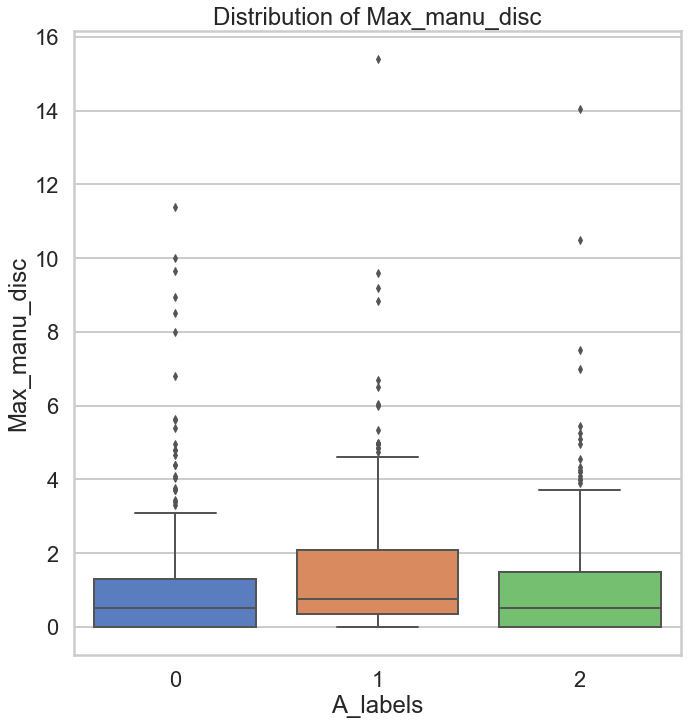

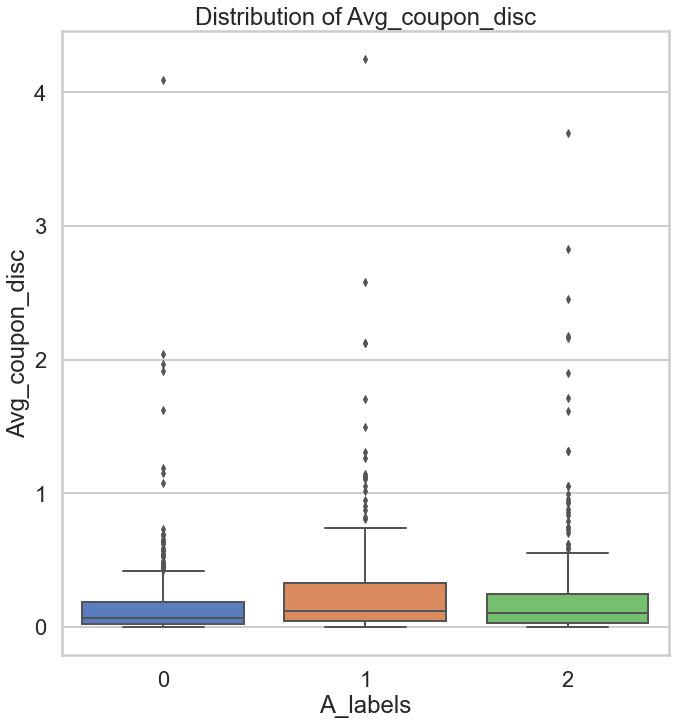

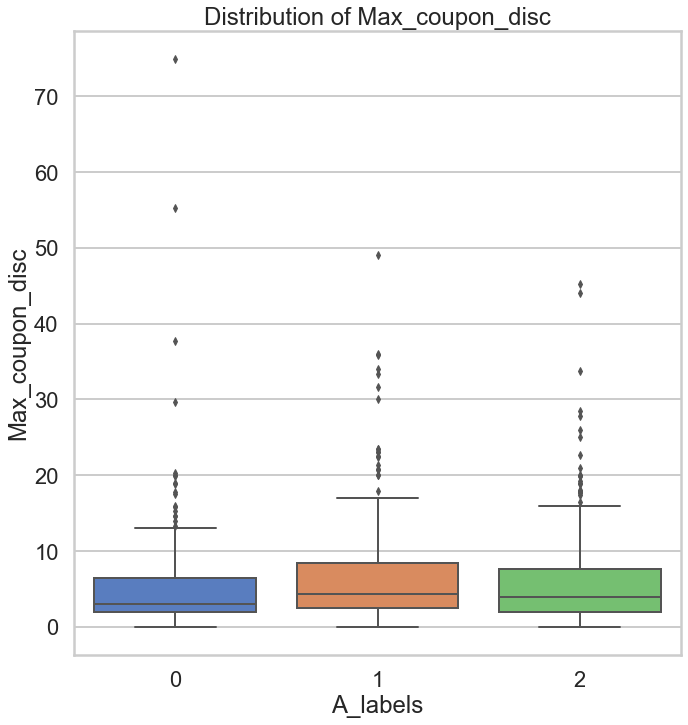

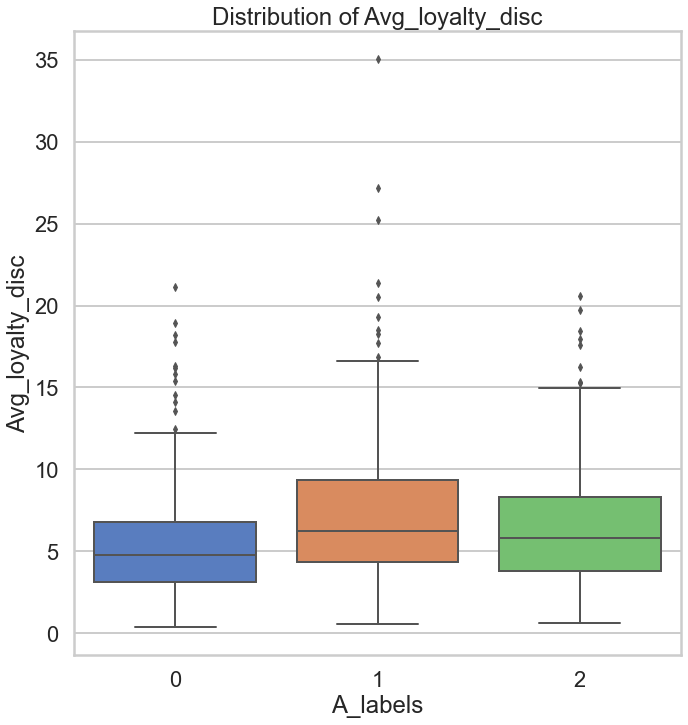

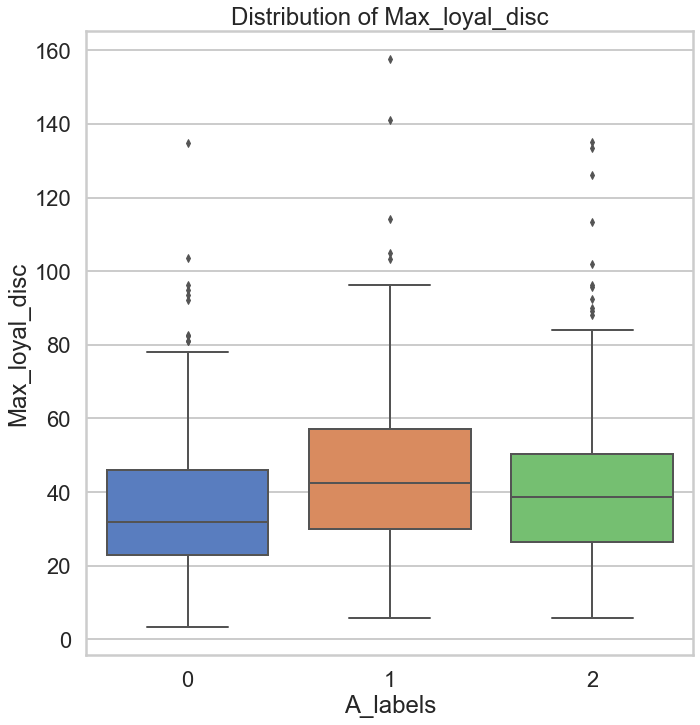

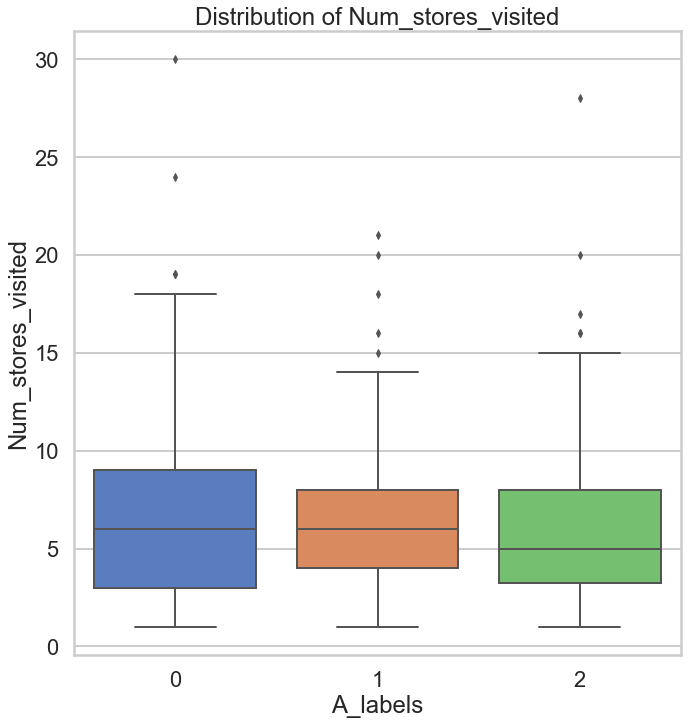

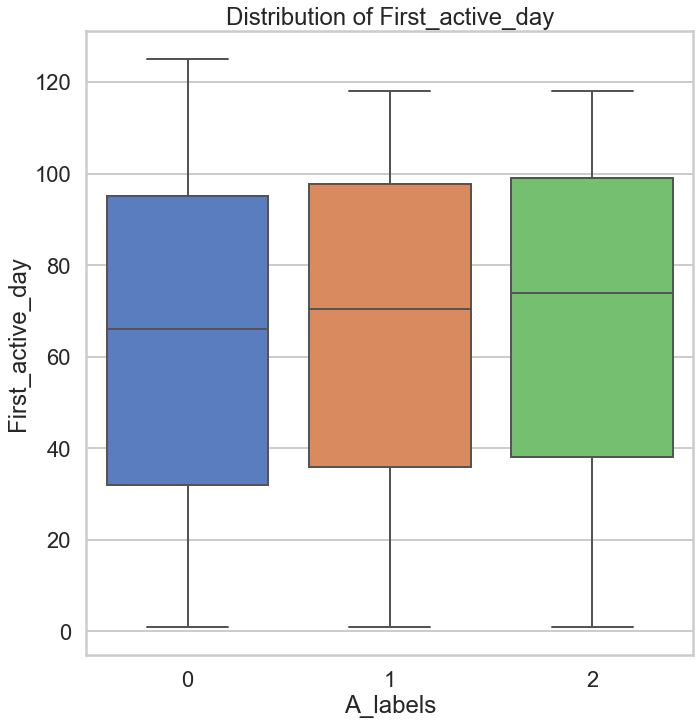

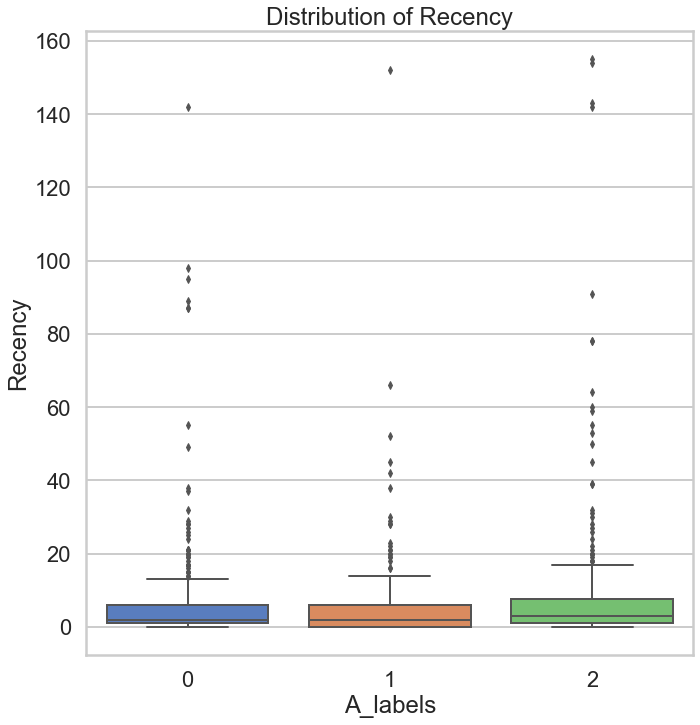

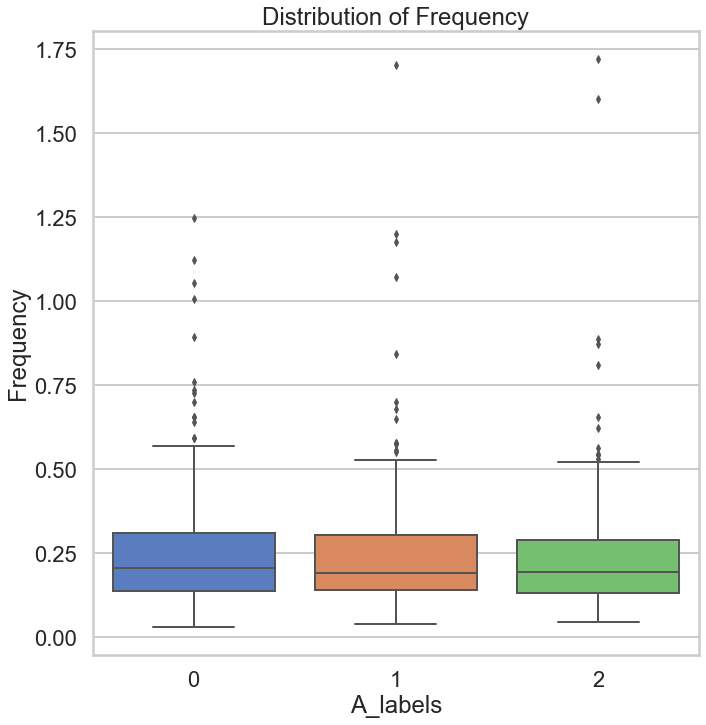

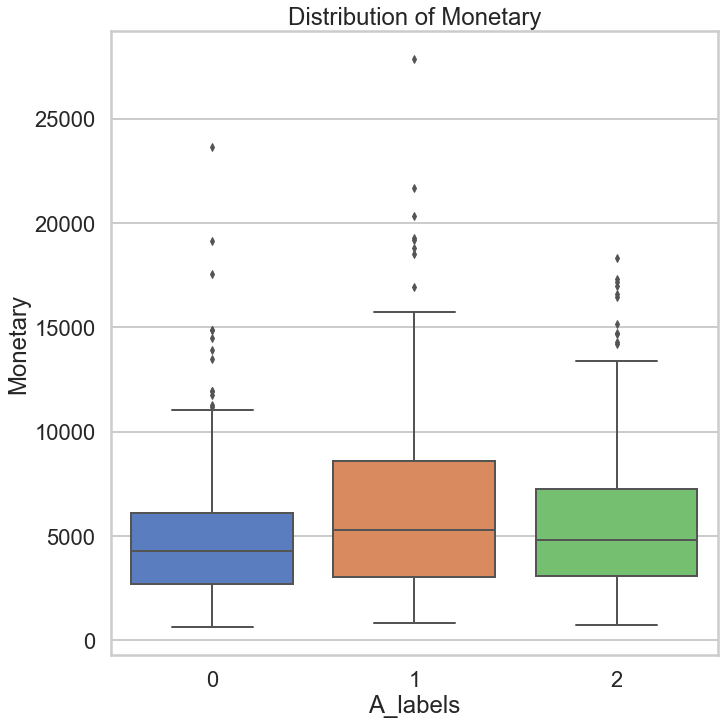

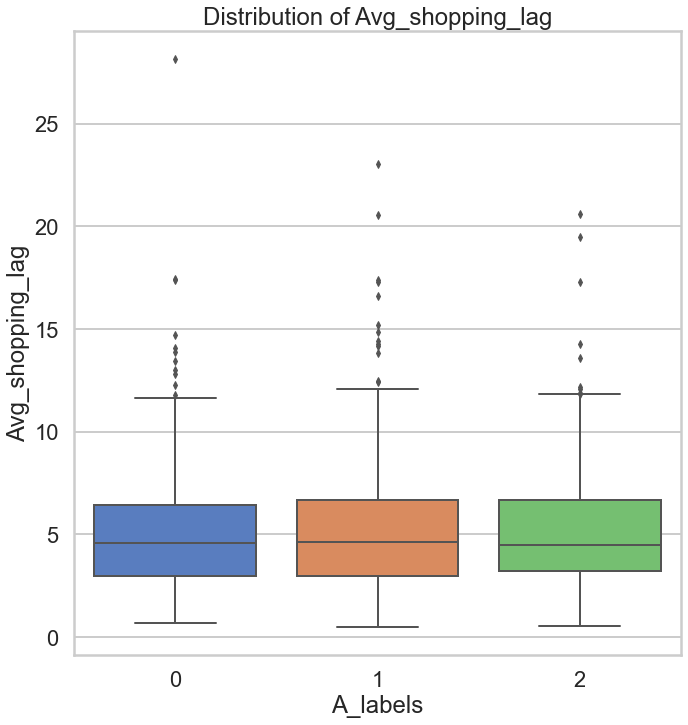

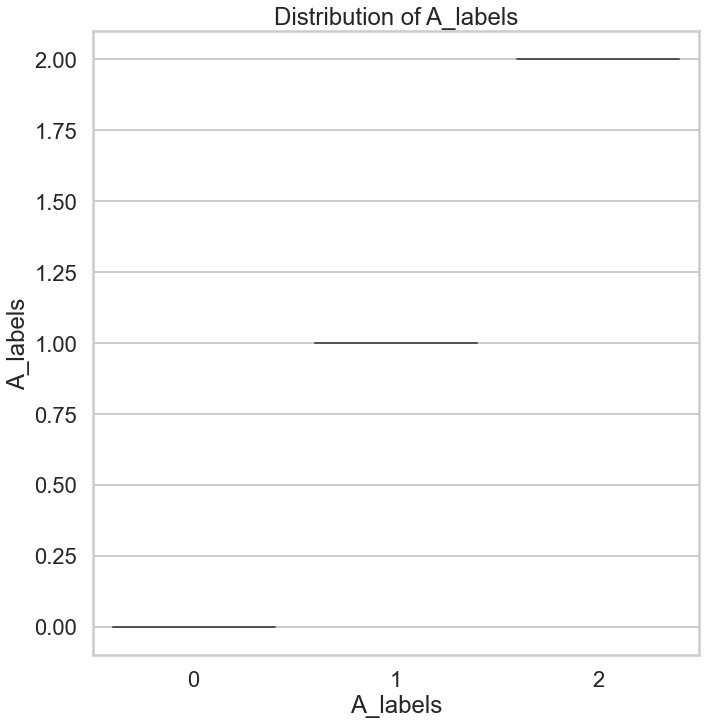

In [20]:
for item in a_num.columns:
    fig, ax1 = plt.subplots(1,1, figsize=(10,10))
    fig.tight_layout()
    sns.boxplot(x='A_labels', y=item, data=a_num, ax=ax1, palette='muted', linewidth=2, order=alabels)
    ax1.set_title('Distribution of {0}'.format(item))

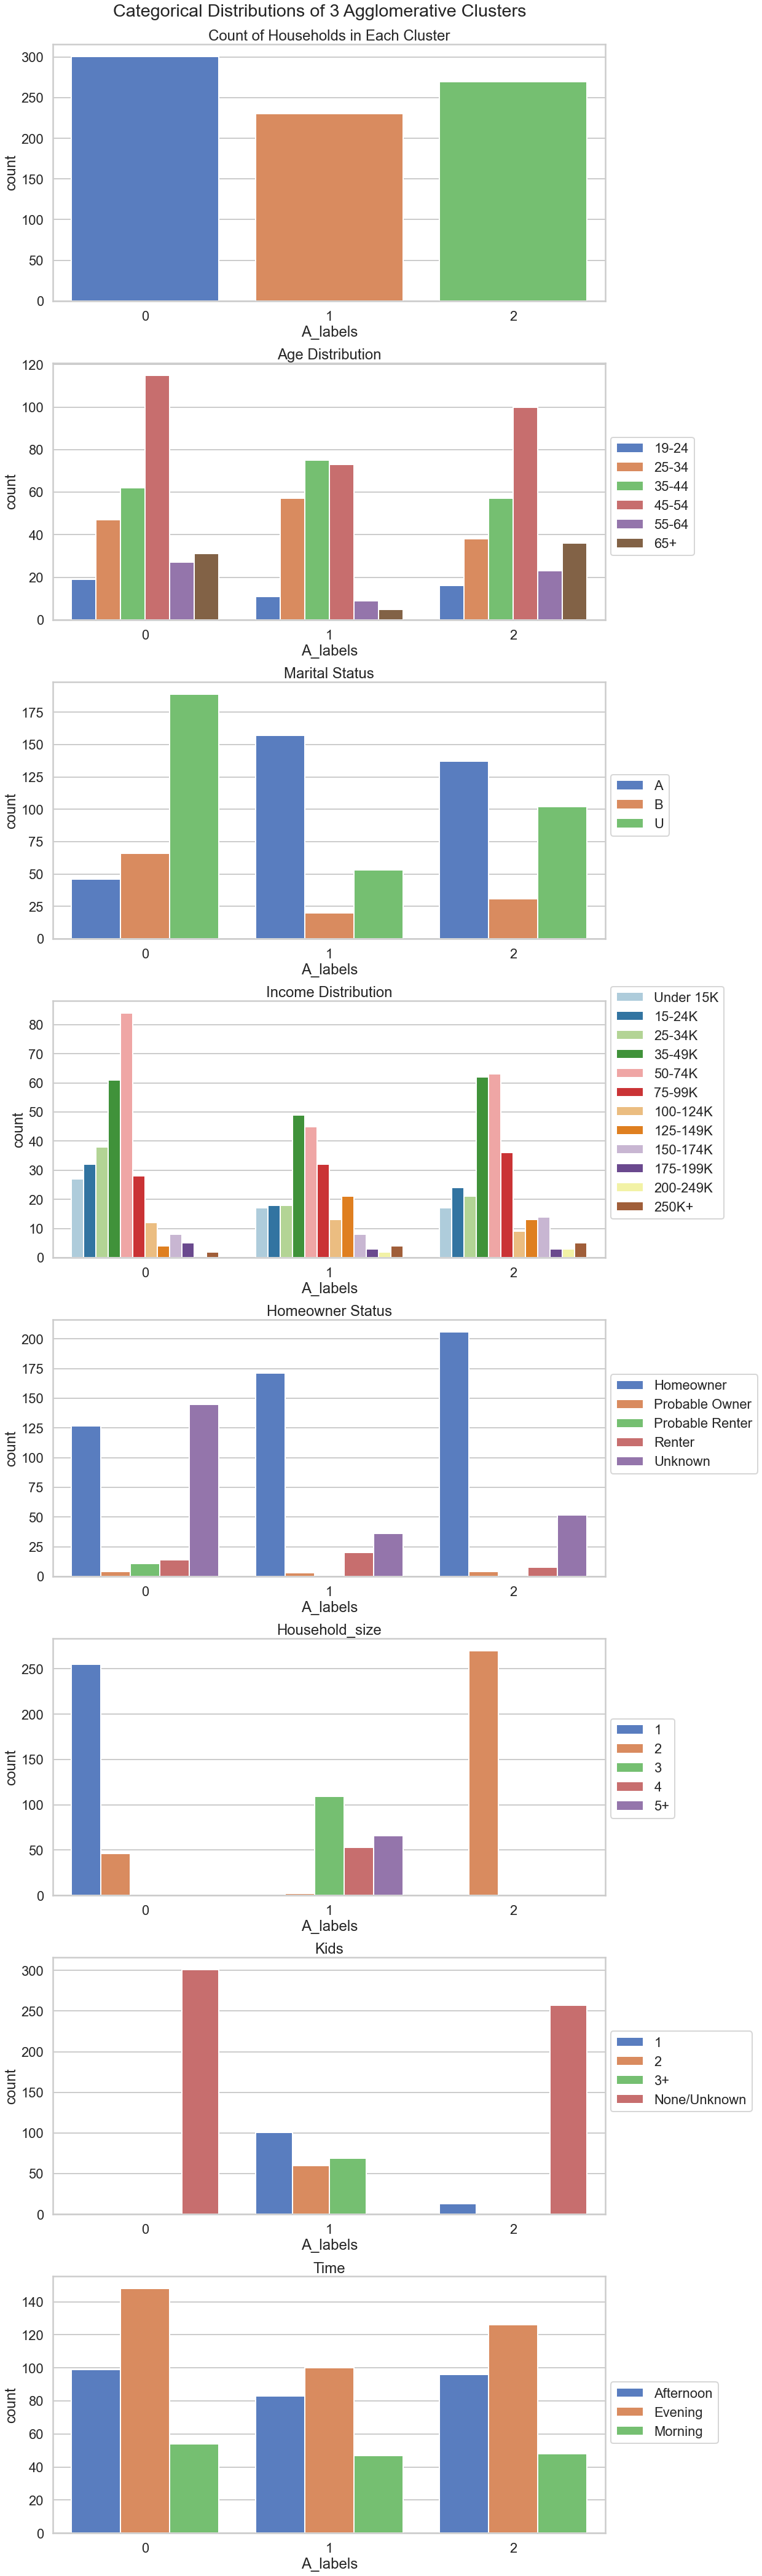

In [21]:
fig, ax = plt.subplots(8, 1, figsize=(15, 60))
fig.tight_layout(pad=2.5)
fig.subplots_adjust(top=0.96)
fig.suptitle('Categorical Distributions of 3 Agglomerative Clusters', y=0.975)
sns.countplot(x='A_labels', data=results, palette='muted', linewidth=2, ax=ax[0])
ax[0].set_title('Count of Households in Each Cluster')

sns.countplot(x='A_labels', hue='Age', data=results, order=alabels, palette='muted', linewidth=2, ax=ax[1], 
             hue_order = np.sort(results.Age.unique()))
ax[1].set_title('Age Distribution')
ax[1].legend(loc=(1.01,0.25))

sns.countplot(x='A_labels', hue='Marital_status', data=results, order=alabels, palette='muted', linewidth=2, 
              ax=ax[2], hue_order = np.sort(results.Marital_status.unique()))
ax[2].set_title('Marital Status')
ax[2].legend(loc=(1.01,0.4))

sns.countplot(x='A_labels', hue='Income', data=results, order=alabels, palette='Paired', linewidth=2, ax=ax[3], 
             hue_order= [ 'Under 15K', '15-24K', '25-34K','35-49K', '50-74K', '75-99K', '100-124K', '125-149K', 
                         '150-174K', '175-199K','200-249K', '250K+'])
ax[3].set_title('Income Distribution')
ax[3].legend(loc=(1.01,0.15))

sns.countplot(x='A_labels', hue='Homeowner_status', data=results, order=alabels, palette='muted', linewidth=2, 
              ax=ax[4], hue_order = np.sort(results.Homeowner_status.unique()))
ax[4].set_title('Homeowner Status')
ax[4].legend(loc=(1.01,0.4))

sns.countplot(x='A_labels', hue='Household_size', data=results, order=alabels, palette='muted', linewidth=2, 
              ax=ax[5], hue_order = np.sort(results.Household_size.unique()))
ax[5].set_title('Household_size')
ax[5].legend(loc=(1.01,0.3))

sns.countplot(x='A_labels', hue='Kids', data=results, order=alabels, palette='muted', linewidth=2, ax=ax[6],
             hue_order = np.sort(results.Kids.unique()))
ax[6].set_title('Kids')
ax[6].legend(loc=(1.01,0.4))

sns.countplot(x='A_labels', hue='Time', data=results, order=alabels, palette='muted', linewidth=2, ax=ax[7], 
             hue_order=np.sort(results.Time.unique()));
ax[7].set_title('Time')
ax[7].legend(loc=(1.01,0.35));

After iterating on the above code passing 2, 3, and 4 clusters to the Agglomerative model, 3 Agglomerative clusters provides the best structure to the data.  I also tried four different options for node linkage, and both single and average linkage resulted in a single cluster; while ward and complete provided similar clusters. The difference between clusters using the ward linkage method is slightly more well defined and is what I'll use for the purpose of analysis.  I'll next examine both transaction behavior as well as demographic indicators that will enable actionable recommendations and actions to take. 



### Customer Segmentation Analysis

Next I'll examine both the agglomerative and k-means generated clusters in order to identify areas of interest in the clusters which should be examined closer. From there, I can provide stronger recommendations around customer behavior.

The first step here is to summarize the distributions of the models around each feature and provide a way in which we can mathematically measure the 'distinctness' of the clusters from one another for eahc feature.  The goal here is to identify which features provide the clearest differentiation between the clusters and will provide the most impactful insights. 

I'm going to do this by assembling information on each cluster (K0, K1 K3, K4, A0, A1, A2) into a single row.  For numerical features we'll take the mean of each cluster, I've already examined all categorical features so this is less important. 

Once I've assembled the average for each cluster/feature intersection I'm going to calculate the range of averages for all K-Means clusters and Agglomerative clusters, then examine the features with the largest range in more detail. 

In [22]:
# Calculating the average for each cluster, setting up a dictionary that 

KMeasures = {'K0':{}, 'K1':{}, 'K2':{}, 'K3':{}}
AMeasures = {'A0':{}, 'A1':{}, 'A2':{}}

In [23]:
# Now I need to rename the cluster labels to match these keys
results['K_labels'].replace({0:'K0', 1:'K1', 2:'K2', 3:'K3'}, inplace=True)
results['A_labels'].replace({0:'A0', 1:'A1', 2:'A2'}, inplace=True)

In [24]:
# Iterate over the keys for each cluster
for key in KMeasures.keys():
    mask = results['K_labels'] == key
    df = results[mask]
    # Iterate over all available features
    for column in results:
        # If the column is numeric take the mean
        if results[column].dtype == 'float':
            X = df[column].mean()
            KMeasures[key][column] = X
        elif results[column].dtype == 'int':
            X = df[column].mean()
            KMeasures[key][column] = X
        # If the feature is categorical take the mode

        
for key in AMeasures.keys():
    mask = results['A_labels'] == key
    df = results[mask]
    for column in results:
        if results[column].dtype == 'float':
            X = df[column].mean()
            AMeasures[key][column] = X
        elif results[column].dtype == 'int':
            X = df[column].mean()
            AMeasures[key][column] = X


In [25]:
K = pd.DataFrame(KMeasures)
A = pd.DataFrame(AMeasures)
# Transpose so the cluster labels are the index
A = A.T
K = K.T
# Convert the data to actual numeric values
A = A.apply(pd.to_numeric)
K = K.apply(pd.to_numeric)
# Concat into a data frame for later usage if needed
Measures = pd.concat([K, A])

In order to identify which features the clusters are the most distinct along I'm going to examine the range of averages and focus on the features where the range of averages is the greatest. 

I'll need to calculate this using the % difference in the min and max average for each feature in order to make the result scale independent.

In [26]:
# Creating a function to calculate the percent difference between each feature's max & min
def minmax(df):
    series = pd.Series(dtype='float64')
    for column in df.columns:
        MAX = df[column].max()
        MIN = df[column].min()
        PERCENT = (MAX-MIN)/MIN
        series[column] = PERCENT
    return series

In [27]:
# Applying new function to both dataframes of averages
Aresults = minmax(A)
Kresults = minmax(K)
# Sorting the results in descending order of the largest % difference between the min and max average of each feature
Aresults = Aresults.sort_values(ascending=False)
Kresults = Kresults.sort_values(ascending=False)

In [28]:
Aresults.head(12)

Recency                    0.609552
Avg_coupon_disc            0.572007
Avg_manu_disc              0.533501
Percent_CouponsRedeemed    0.438544
Max_manu_disc              0.413082
PercentTypeC               0.397412
Avg_loyalty_disc           0.354780
Max_coupon_disc            0.351253
Avg_basket_sales_value     0.293292
Monetary                   0.291152
PercentTypeA               0.256203
Avg_num_items              0.253583
dtype: float64

In [29]:
Kresults.head(11)

PercentTypeC                1.195416
Avg_manu_disc               0.910071
Min_basket_sales_value      0.675000
Recency                     0.674837
Avg_coupon_disc             0.635256
Max_manu_disc               0.482636
Percent_CouponsRedeemed     0.442713
Avg_loyalty_disc            0.370426
Avg_num_items               0.355144
Max_coupon_disc             0.336294
Percent_CampaignRedeemed    0.335480
dtype: float64

Based on the above I plan to examine ten features for each clustering model.  The goal here is to identify both business insights that could potentially have a high impact, and also identify if one model provides more relevant insights.  


**For K-means clusters I'll examine these ten features:**


1. Recency Score (# of days since last purchase)
2. Average Coupon Discount
3. Average Manufacturer Discount (fronted by the store and paid back by the product manufacturer)
4. Percent of Coupons Redeemed
5. Max Manufacturer Discount
6. Average Loyalty Discount
7. Max Coupon Discount
8. Average Sales Value
9. Monetary Score (Total Sales Value)
10. Average Number of Items


**For Agglomerative clusters I'll examine these ten features:**


1. Average Manufacturer Discount
2. Minimum Sales Value
3. Recency Score
4. Average Coupon Discount
5. Maximum Manufacturer Discount
6. Percent of Coupons Redeemed
7. Average Loyalty Discount
8. Average Number of Items
9. Maximum Coupon Discount
10. Percent of Campaigns Redeemed


Additionally, I plan to examine the percentage of campaigns and coupons redeemed in relation to the type of campaigns which were sent to each cluster to determine if one campaign is more effective overall, or is more effective on a particular cluster. 

### K-Means Analysis

I've previously examined the categorical features for each cluster, and those can be summed up as follows:

- **K2**:  The largest cluster produced by this model, K2 is overwhelmingly older, with most of it's members in the 45-54 year old age group and double the amount of members over the age of 65 as any other cluster.   It also tends to be wealthier on average, with twice as many members earning over 150-thousand as any other cluster.  Finally, the K2 cluster is exclusively made up of households which have 2 members. 

- **K0**: The second largest cluster in this model is demographically distinguished by the number of children in each household.  This is the only cluster with any children present, and each household is made up of 3 or more people as a result. Additionally, this cluster tends to skew younger, with most households anywhere from the age of 25 to 44.   Generally speaking this cluster has a normal income distribution, but there is a spike in income from 125-149k which is notable. 

- **K3**: The third cluster is largely made up of 45-54 year olds with more than double the number of households in that age group as any other age.  Generally these households tend to skew poorer than the other clusters, are almost exclusively 1-person households, and heavily favor shopping in the evening. 

- **K1**: This cluster is made up of the households which don't really fit in the other cluster.  It's households have an even age distribution, are single, but have 1 or 2 people in each household. 

How distinct is the divide along household sizes and marital status in both clustering models?


Key differences between clusters: 

-[x] Age

-[ ] Income

-[x] Household Size

-[ ] Child Status

-[ ] Marital Status?



-[ ] total value

-[ ] average value

-[ ] frequency

-[x] Average Loyalty Discount

-[ ] percent displayed purchased

-[ ] percent displayed mailer

-[ ] most frequent department

-[ ] count sub category

### Examining clusters for segmentation and business insights

In every model that I examined household size, marital status, and child status seemed to be key differentiators along which clusters were formed demographically.  Similarly, there were distinct differences between clusters with loyalty discounts, total value, shopping frequency, and the percentage of items purchased on display.

Below what I'm going to do is to analyze the clusters focusing on both their demographic makeup (and thus how they may be extrapolated to new customers with no shopping history), as well as on key behavioral differences that will change how these customers can be targeted. 

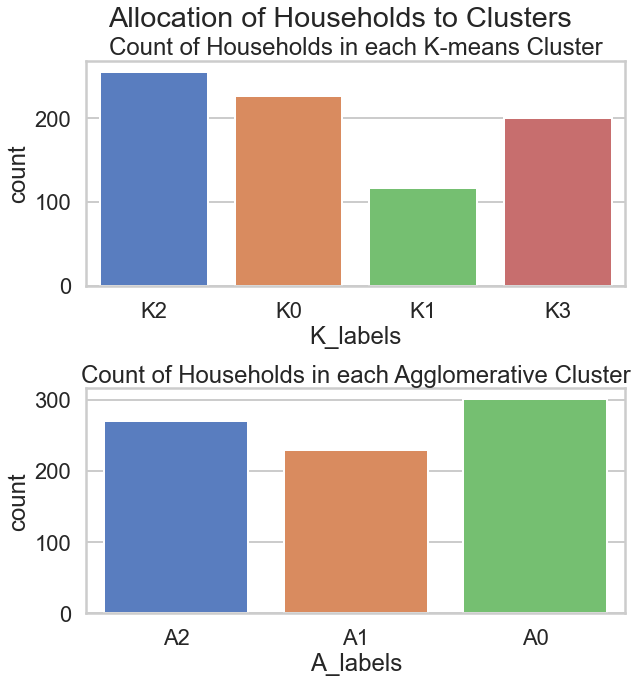

In [30]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
fig.tight_layout(pad=2.5)
fig.subplots_adjust(top=0.9)
fig.suptitle('Allocation of Households to Clusters', y=0.975)

sns.countplot(x='K_labels', data=results, palette='muted', linewidth=2, ax=ax[0])
ax[0].set_title('Count of Households in each K-means Cluster')

sns.countplot(x='A_labels', data=results, palette='muted', linewidth=2, ax=ax[1])
ax[1].set_title('Count of Households in each Agglomerative Cluster');

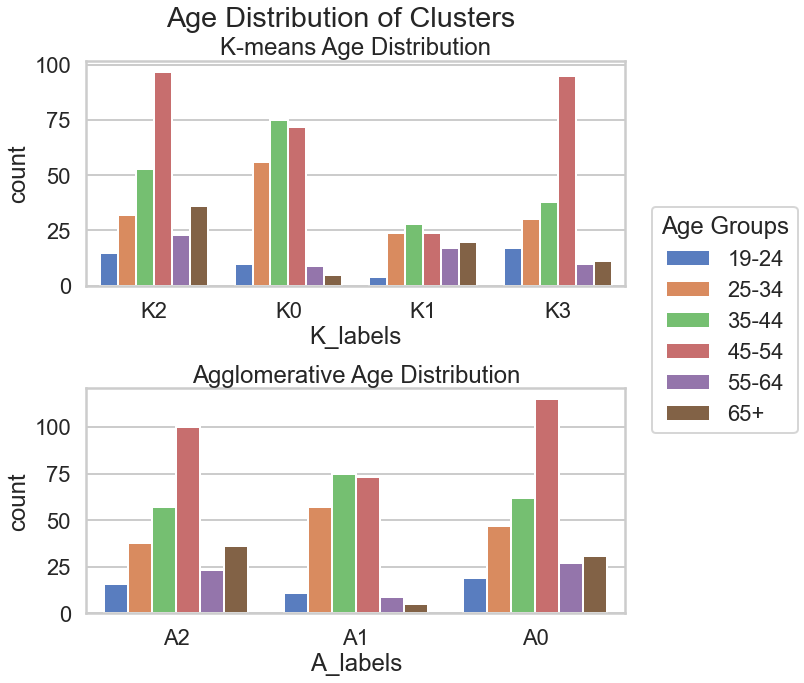

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
fig.tight_layout(pad=2.5)
fig.subplots_adjust(top=0.9)
fig.suptitle('Age Distribution of Clusters', y=0.975)

sns.countplot(x='K_labels', hue='Age', data=results, palette='muted', linewidth=2, ax=ax[0], 
             hue_order = np.sort(results.Age.unique()))
ax[0].set_title('K-means Age Distribution')
# Hides the legend from the first plot
ax[0].legend([],[], frameon=False)

sns.countplot(x='A_labels', hue='Age', data=results, palette='muted', linewidth=2, ax=ax[1], 
             hue_order = np.sort(results.Age.unique()))
ax[1].set_title('Agglomerative Age Distribution')
# Shifts legend from the second plot up to serve both subplots
ax[1].legend(loc=(1.05,0.8), title='Age Groups');

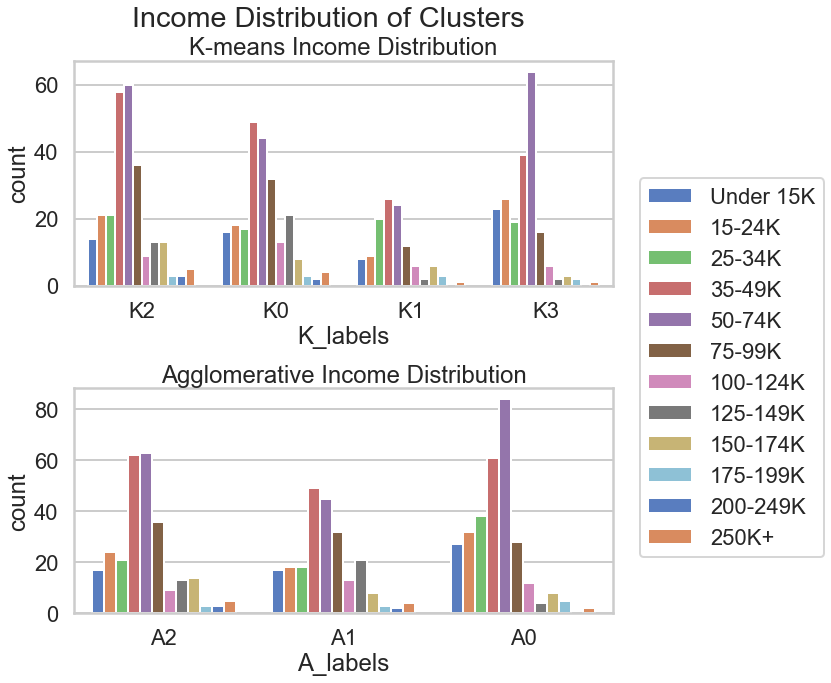

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
fig.tight_layout(pad=2.5)
fig.subplots_adjust(top=0.9)
fig.suptitle('Income Distribution of Clusters', y=0.975)

sns.countplot(x='K_labels', hue='Income', data=results, palette='muted', linewidth=2, ax=ax[0], 
             hue_order = [ 'Under 15K', '15-24K', '25-34K','35-49K', '50-74K', '75-99K', '100-124K', '125-149K', 
                         '150-174K', '175-199K','200-249K', '250K+'])
ax[0].set_title('K-means Income Distribution')
# removes the legend from the first plot 
ax[0].legend([],[], frameon=False)

sns.countplot(x='A_labels', hue='Income', data=results, palette='muted', linewidth=2, ax=ax[1], 
             hue_order = [ 'Under 15K', '15-24K', '25-34K','35-49K', '50-74K', '75-99K', '100-124K', '125-149K', 
                         '150-174K', '175-199K','200-249K', '250K+'])
ax[1].set_title('Agglomerative Income Distribution')
# Shifts the second legend to serve both subplots
ax[1].legend(loc=(1.05,0.25));

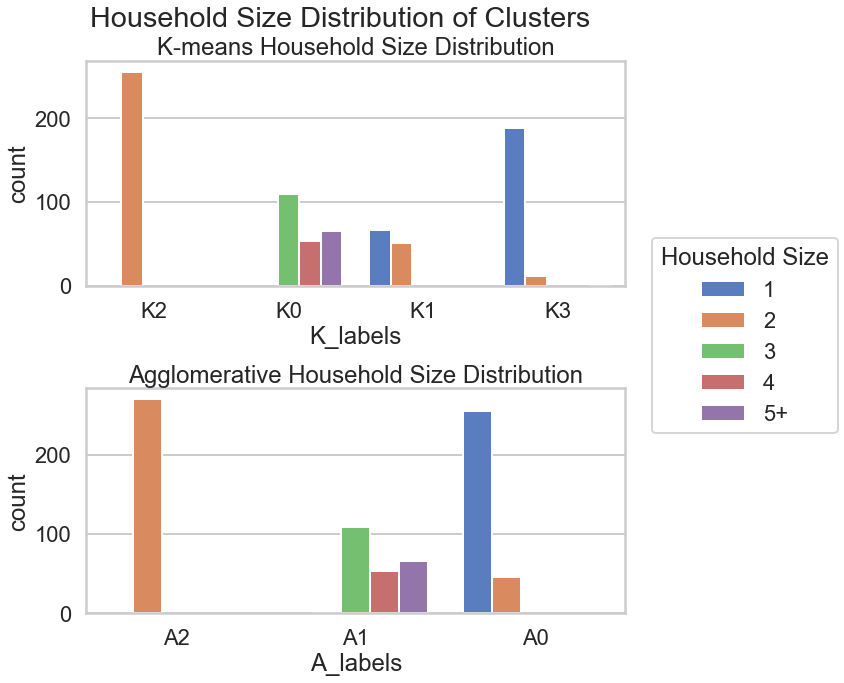

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
fig.tight_layout(pad=2.5)
fig.subplots_adjust(top=0.9)
fig.suptitle('Household Size Distribution of Clusters', y=0.975)

sns.countplot(x='K_labels', hue='Household_size', data=results, palette='muted', linewidth=2, ax=ax[0], 
             hue_order = np.sort(results.Household_size.unique()))
ax[0].set_title('K-means Household Size Distribution')
ax[0].legend([],[], frameon=False)

sns.countplot(x='A_labels', hue='Household_size', data=results, palette='muted', linewidth=2, ax=ax[1], 
             hue_order = np.sort(results.Household_size.unique()))
ax[1].set_title('Agglomerative Household Size Distribution')
ax[1].legend(loc=(1.05,0.8), title='Household Size');

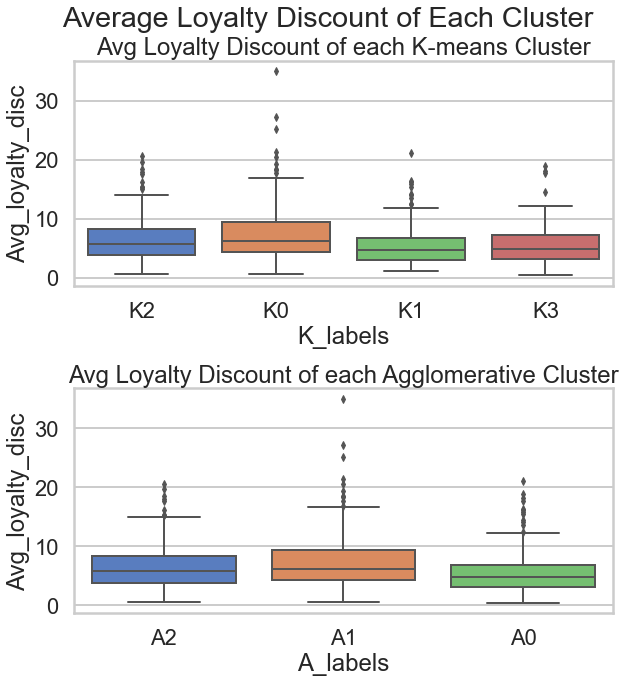

In [34]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
fig.tight_layout(pad=2.5)
fig.subplots_adjust(top=0.9)
fig.suptitle('Average Loyalty Discount of Each Cluster', y=0.975)

sns.boxplot(x='K_labels', y='Avg_loyalty_disc', data=results, palette='muted', linewidth=2, ax=ax[0])
ax[0].set_title('Avg Loyalty Discount of each K-means Cluster')

sns.boxplot(x='A_labels', y='Avg_loyalty_disc', data=results, palette='muted', linewidth=2, ax=ax[1])
ax[1].set_title('Avg Loyalty Discount of each Agglomerative Cluster');

Create a table of each cluster as a row and each feature as a column, values are average or mode for each cluster. 

Use this to assess which features are the most important for differentiating clusters
 visualize those differences